In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris, make_moons, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.tree import DecisionTreeClassifier, plot_tree #DT #поможет нам визуализировать деревья
from sklearn.ensemble import RandomForestClassifier #RF
from xgboost import XGBClassifier #xgb
from scipy.ndimage import rotate #к деревьям отношения не имеет, нужен нам для экспериментов с пространством
import shap #SHAP-values

# Вступление по деревьям

## Базовый вызов DecisionTree

In [ ]:
#Загрузка данных
iris = load_iris()
X, y = iris.data, iris.target

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
#Оставим только два класса пока
X_reshaped = np.concatenate((np.column_stack((X[:, 0][y==0], X[:, 1][y==0])), np.column_stack((X[:, 0][y==1], X[:, 1][y==1]))), axis=0)
y_reshaped = np.concatenate((np.zeros(len(X[:, 0][y==0])), np.ones(len(X[:, 0][y==1]))), axis=0)

In [ ]:
y_reshaped

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
#Создание. Обучение. Предсказание.
clf = DecisionTreeClassifier()
clf = clf.fit(X_reshaped, y_reshaped)
y_pred = clf.predict(X_reshaped)

In [ ]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
accuracy_score(y_reshaped, y_pred)

1.0

## Напоминание про несколько метрик для бинарной классификации

**Gini**

Внутри листа рассчитываем $Gini$ - вероятность того, что случайно выбранные два объекта в данном листе относятся к разным классам.

$$Gini = \sum_{i=1}^{m} p_i(1 - p_i) = 1 - \sum_{i=1}^{m} p_i^2$$

где $m$ — количество классов, а $p_i$ — доля объектов класса $i$.

**Impurity decrease**

Сравниваем возможные разбиения между собой для выбора наилучшего.

$$imputity\_decrease = Gini_0 - (\frac{n_1}{n_1+n_2}Gini_1 + \frac{n_2}{n_1+n_2}Gini_2)$$

где $Gini_0$ — значение метрики в родительском узле, $Gini_1$ и $Gini_2$ — значение метрики в дочерних узлах,
$n_1$ и $n_2$ — количество объектов в соответствующих классах.


<div style="text-align: center;">
    <img src="./pics/impurity_new.png" width="900px"/>
</div>

<br>

$$p = \frac{105+33}{105+33+34+125} = 0.88$$

<br>

$$Gini_0 = 0.498$$


## Почему DT всё же плохи

К сожалению они **неустойчивы**.

Это значит, что, например, если мы будем сэмплировать выборки из наших данных, то решение окажется разным.

Здесь мы разобьём данных на трейн и тест два раза и посмотрим что будет.

In [ ]:
# Обновим датасет
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target != 1

In [ ]:
# первый набор точек
X_train1, X_test1, y_train1, y_test1 = train_test_split(df[data.feature_names], df["target"],
                                                        random_state=1408)
clf1 = DecisionTreeClassifier(max_depth=3)
clf1.fit(X_train1, y_train1)

# второй набор точек
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[data.feature_names], df["target"],
                                                        random_state=1803)
clf2 = DecisionTreeClassifier(max_depth=3)
clf2.fit(X_train2, y_train2)

print(f'Первый набор: {accuracy_score(y_test1, clf1.predict(X_test1))}. Второй набор: {accuracy_score(y_test2, clf2.predict(X_test2))}.')

Первый набор: 0.9473684210526315. Второй набор: 0.9473684210526315.


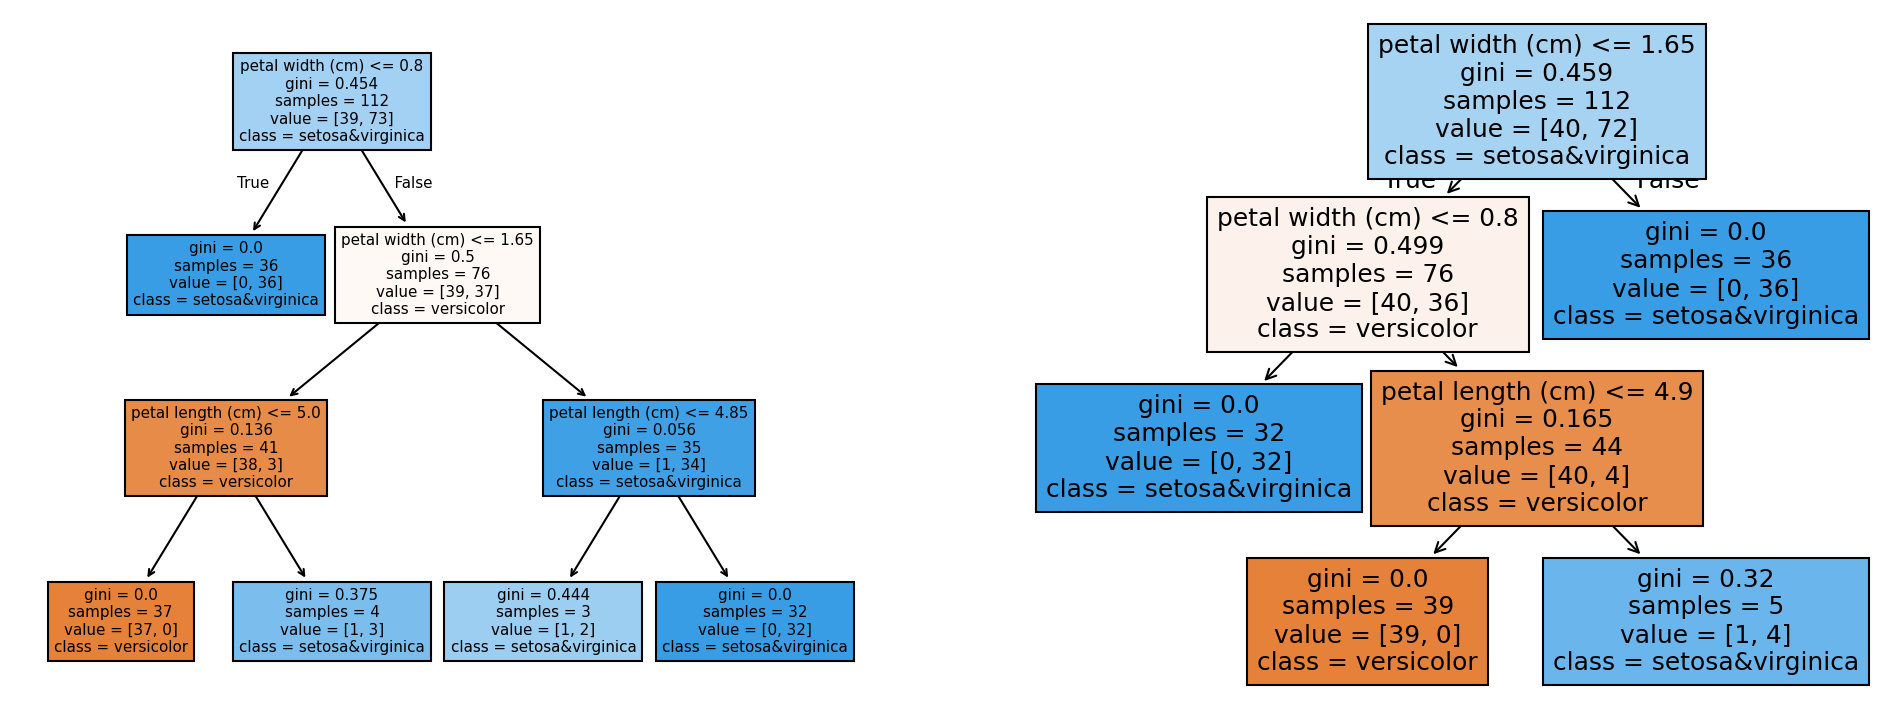

In [ ]:
#Как посмотреть

fn = ["sepal length (cm)", "sepal width (cm)",
      "petal length (cm)", "petal width (cm)"]

cn = ["versicolor", "setosa&virginica"]

fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 6), dpi=150)
plot_tree(clf1,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[0])

plot_tree(clf2,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[1])
plt.show()

Обычно ещё пытаются капнуть глубже, но и это не исправит ситуацию

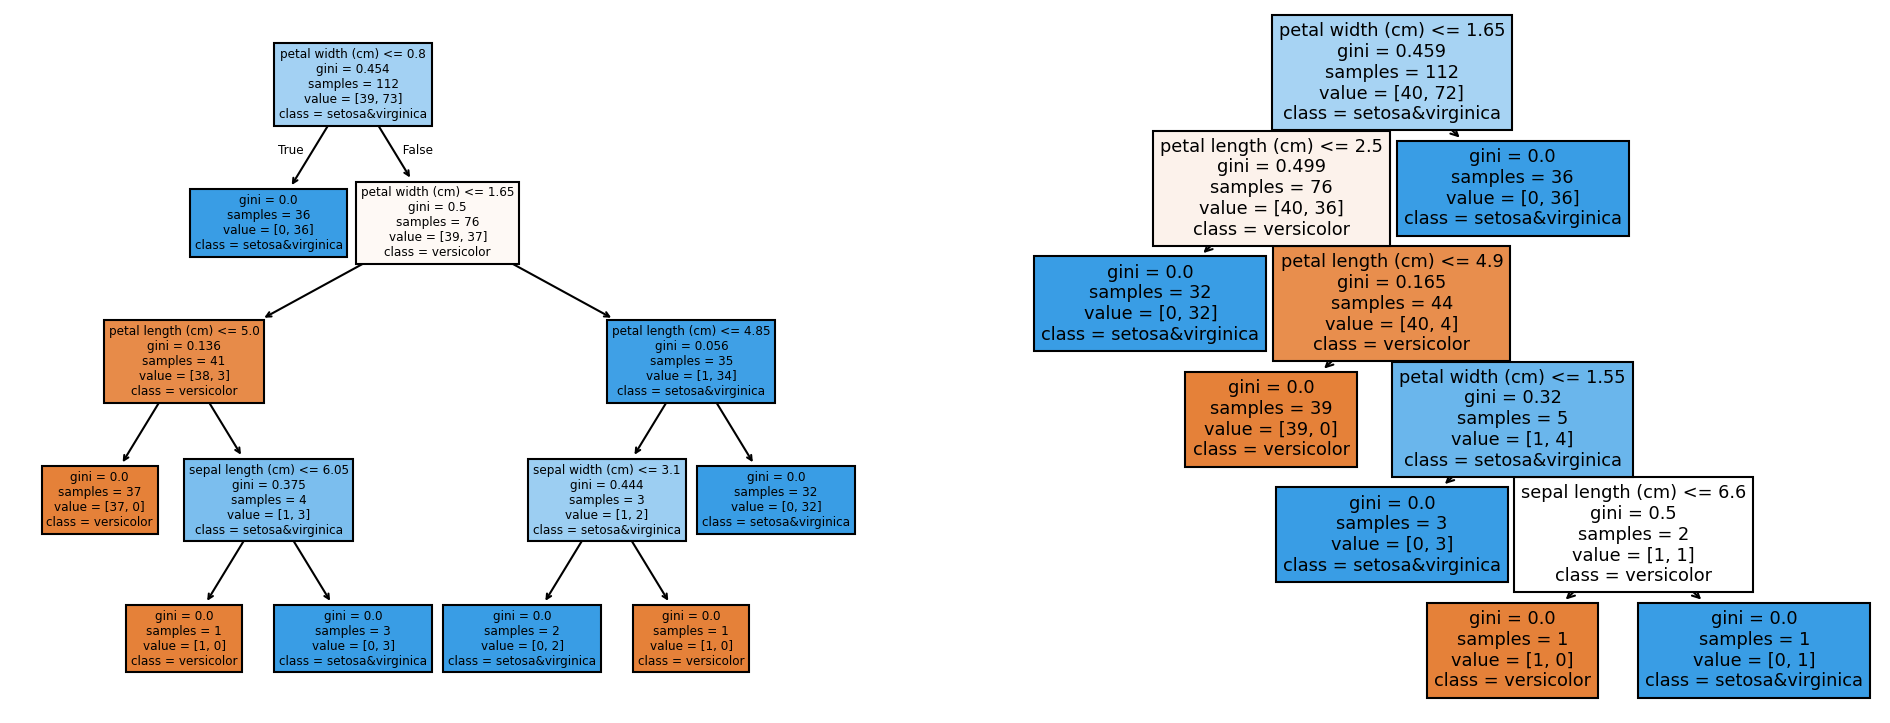

In [ ]:
# первый набор точек
clf1 = DecisionTreeClassifier(max_depth=10)
clf1.fit(X_train1, y_train1)

# второй набор точек
clf2 = DecisionTreeClassifier(max_depth=10)
clf2.fit(X_train2, y_train2)


fn = ["sepal length (cm)", "sepal width (cm)",
      "petal length (cm)", "petal width (cm)"]

cn = ["versicolor", "setosa&virginica"]

fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 6), dpi=150)
plot_tree(clf1,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[0])

plot_tree(clf2,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[1])
plt.show()

При большой глубине они обычно **переобучаются**

Если алгоритм при небольшом изменении признаков сильно меняет свое решение, это, как правило, указывает на переобучение. Алгоритм сильно реагируют на любой шум в данных - доверять его решениям не стоит.

Будем использовать исскуственные данные и нереальный рисунок карандашом для визуализации разделяющих поверхностей.

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

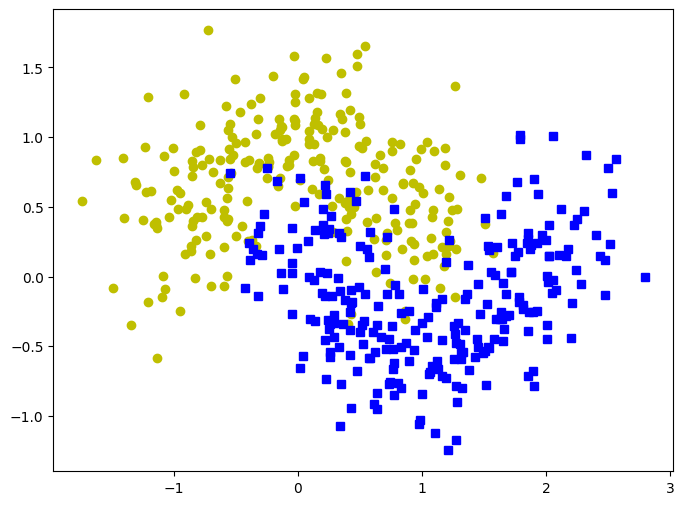

In [ ]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()


Тут не разделишь руками. Попробуем взять дерево какой-нибудь глубины ~20. Строим модель один раз

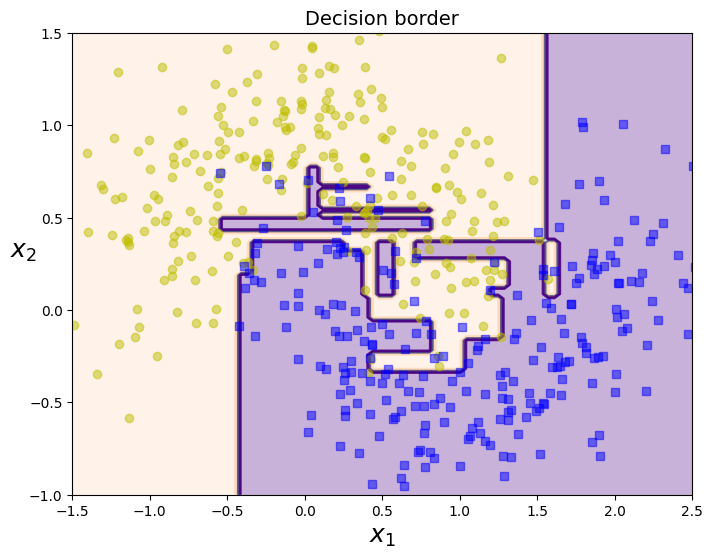

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
clf = DecisionTreeClassifier(max_depth=20, random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

А теперь опять посемплируем датасеты для трейна и теста

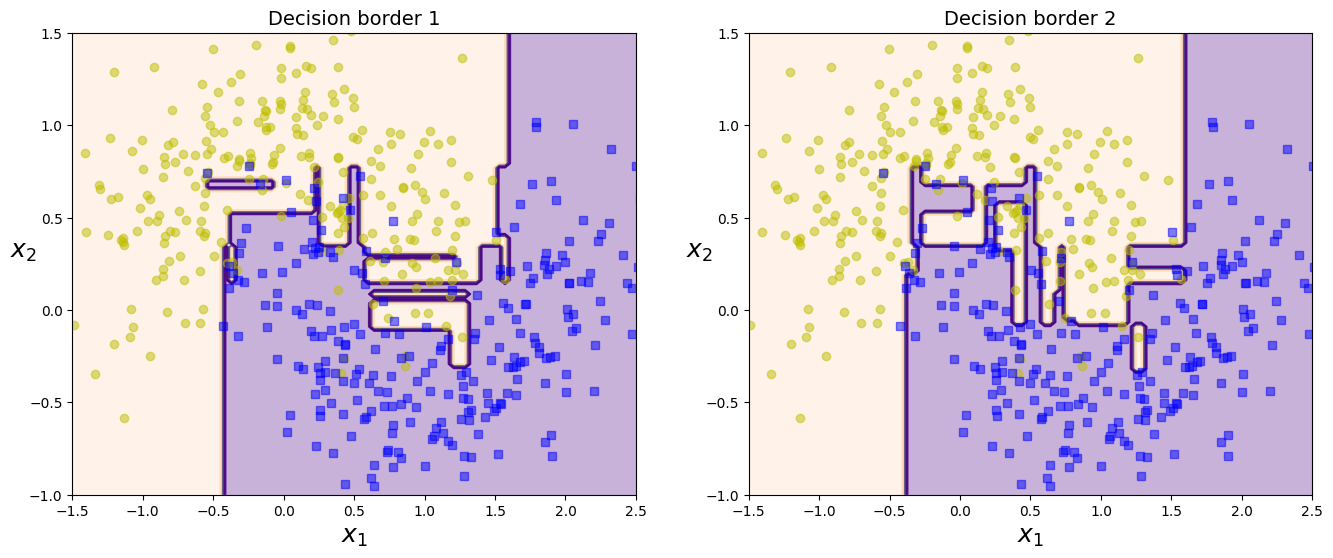

In [ ]:
# первый набор точек
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=1)
clf1 = DecisionTreeClassifier(max_depth=20, random_state=42)
clf1.fit(X_train1, y_train1)

# второй набор точек
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=2)
clf2 = DecisionTreeClassifier(max_depth=20, random_state=42)
clf2.fit(X_train2, y_train2)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X, y)
plt.title("Decision border 1", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X, y)
plt.title("Decision border 2", fontsize=14)
plt.show()

Ранее мы видели, что меняются границы на деревьях, тут вы их видите своими глазами. Мало того, что границы рваные, они ещё и разные, а мы ведь просто посемплировали один и тот же датасет.

> Было ли у нас про variance? Если нет, читай дальше

### Bias Variance trade-off

То что мы посмотрели чуть выше формулируется как "наша модель имеет высокий **variance**", по смыслу это что-то около "хорошо запомнила данные обучающей выборки". Но разве этого мы хотели?

В машинном обучении две главные цели:



*   Минимизировать ошибку на трейне во время обучения
*   Минимизировать гэп между ошибками на трейне и тесте

Отсюда и произрастают две проблемы: недообучение (underfitting) и переобучение (overfitting). И им же соответствуют две сущности bias и variance.

Давайте разбираться!



Представьте, что у вас есть **набор данных**. Он беусловно **зашумлён** (особенно, если это что-то биологическое - там иногда из шума рождается жизнь).

И допустим, что эти данные на самом деле **распределены по параболе**, т.е. идеальная, и реальная, функция этих данных - парабола $y = ax^{2} + bx + c$.

Но мы то не знаем этого. И начинаем перебирать разные варианты.


Если мы возьмём слишком простую модель (думаем, почему модель простая?), например, линейную $ŷ = kx + b$, то вот что выйдет.

**Bias**

<img src="./pics/high-bias-plot.png" width="600px">

Мы на самом деле даже с трейном не справились, что говорить уже про тест. Даже **на трейне ошибка велика** (разница между нашей оценкой $ŷ$, точкой на прямой, и точкой данных на параболе $y$ будет большая).

Тогда говорят, что это **высокий bias**. Потому что мы наши параметры "недооценили" и всегда есть сдвиг по мат.ожиданию этого параметра (но это слишком в математику).

Как много данных мы бы не брали, как много моделей бы не запускали - наша модель в принципе не способна поймать паттерн в данных.

**Variance**

Давайте возьмём полином большой степени, ну например 5-ой: $ŷ = ax^{5} + bx^{4} + cx^{3} + dx^{2} +ex + f$

<img src="./pics/varianceplot.png" width="600px">

"Идеально!" - скажете вы, но "нет" - отвечу я.

Не кажется ли вам, что наша модель теперь выучила и шум. Модель переобучилась. Она "идеальна" на трейн сете и ошибка теперь минимальна (если не 0).

Проявляться это будет в том, что модель будет очень сильно зависеть от обучающей выборки - небольшое изменение в обучающей выборке будет менять много коэффициентов модели, и решение будет "рваным" - достаточно немного поменять признаки объекта, и предсказание меняется очень резко.

Но если вы дадите ей тест, то там ошибка будет большой. А мы хотим, чтобы 1) ошибка на трейне была мала, 2) разница ошибок на трейне и тесте были соизмеримы.

Мы пришли к **высокому variance**, господа!

**Bias-variance tradeoff**

Обе ситуации нас не устраивают. На одной высокий bias, т.е. недообучение, на второй - высокий variance, т.е. переобучение. Нам придётся ловить баланс. И этим балансом был **Bias-variance tradeoff**

<img src="./pics/bias_vs_var.png" width= "600px;"/>

**Irreducible error**

А если мы всё же возьмём гиперболу, т.е. нашу реальную функцию? Чего мы будем ожидать?

Bias = 0, Variance = 0.

Однако, у нас **есть ошибки в измерении** самой предсказываемой величины. Мы же говорили про шум. Из-за этого наша модель всегда будет иметь некий уровень ошибки, ниже которого опуститься нельзя.

В реальности же, когда реальную модель данных угадать в точности почти невозможно, есть **bias-variance tradeoff** - нельзя бесконечно уменьшать и Bias, и Variance. Есть какая-то точка оптимума. С какого-то момента при уменьшении Bias начнет увеличиваться Variance, и наоборот. При этом, можно построить связь этих величин с увеличинием сложности модели (capacity)

**А что с деревьями?**

Дерева **малой глубины** имеет малую сложнось - и **высокий bias**. Дерево **большой глубины** имеет высокую сложность - и **высокий variance**.

Можно подобрать для дерева идеальную capacity, когда Bias и Variance будут суммарно давать наименьший вклад в ошибку. Этим мы занимаемся при подборе параметров. Но есть и другие способы борьбы с variance и/или bias, но об этом потом.



# Почему ансамбли хороши

Заметим, что если бы могли говорить не просто решение дерева, а привязывать к этому какую-то статистику, например, сколько деревьев, построенных по подобной процедуре, приняли такое же решение - было бы легче.

Если наложить решающие границы 100 решающих деревьев, построенных на разных выборках из X, y, то мы увидим, что "хорошие области", соответствующие реальному разделению данных будут общими между деревьями, а плохие - индивидуальны. К сожалению, в реальности, мы не можем брать бесконечное число наборов данных из генеральной совокупности (представленной в данном случае X, y)

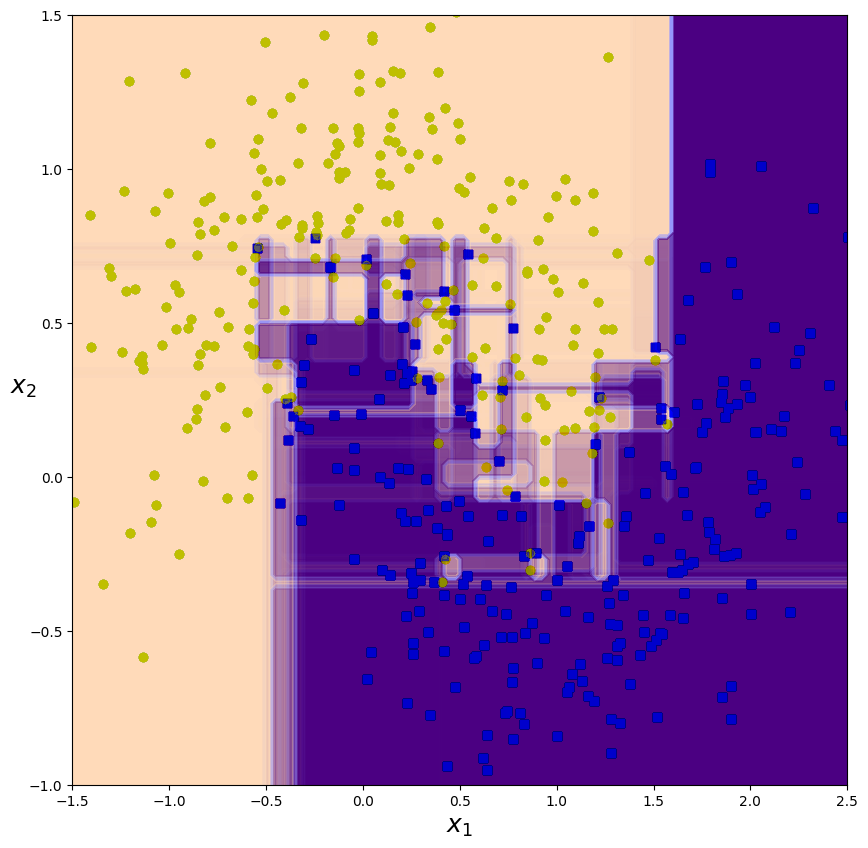

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(1, 101):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    clf = DecisionTreeClassifier(max_depth=20, random_state=0)
    clf.fit(X_train, y_train)
    plot_decision_boundary(clf, X, y, alpha=0.02, contour=False)

plt.show()

Мы не будем здесь разбирать варианты деревьев и т.д., но в интернете много картинок как хороши ансамбли.

Рубрика "ЭКСПЕРИМЕНТЫ"

# Space rotation sensitivity

Здесь мы поэкспериментируем с данными, чтобы лучше понять как ищутся границы моделью DecisionTree. 

Мы будем использовать данные и вращать их на 30, 45, 90, 135, 180, и 57 градусов (представьте, что мы вращаем оси, или вращаем само пространство данных - не важно, движение относительно), чтобы посмотреть, как это повлияет на сплиттинг с помощью дерева решений.

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

## Исходные данные

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target

In [ ]:
X_reshaped = np.concatenate((np.column_stack((X[:, 0][y==0], X[:, 1][y==0])), np.column_stack((X[:, 0][y==1], X[:, 1][y==1]))), axis=0)
y_reshaped = np.concatenate((np.zeros(len(X[:, 0][y==0])), np.ones(len(X[:, 0][y==1]))), axis=0)

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_reshaped, y_reshaped)

[Text(0.5909090909090909, 0.9, 'x[0] <= 5.45\ngini = 0.5\nsamples = 100\nvalue = [50, 50]'),
 Text(0.36363636363636365, 0.7, 'x[1] <= 2.8\ngini = 0.208\nsamples = 51\nvalue = [45, 6]'),
 Text(0.4772727272727273, 0.8, 'True  '),
 Text(0.18181818181818182, 0.5, 'x[0] <= 4.7\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.09090909090909091, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.2727272727272727, 0.3, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.5454545454545454, 0.5, 'x[0] <= 5.35\ngini = 0.043\nsamples = 45\nvalue = [44, 1]'),
 Text(0.45454545454545453, 0.3, 'gini = 0.0\nsamples = 39\nvalue = [39, 0]'),
 Text(0.6363636363636364, 0.3, 'x[1] <= 3.2\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(0.5454545454545454, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.7272727272727273, 0.1, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.8181818181818182, 0.7, 'x[1] <= 3.45\ngini = 0.183\nsamples = 49\nvalue = [5, 44]'),
 Text(0.7045454545454546, 

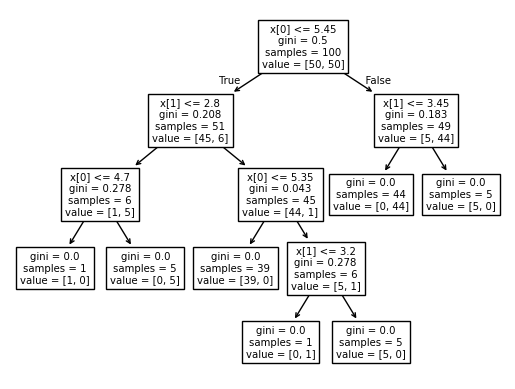

In [ ]:
plot_tree(clf)

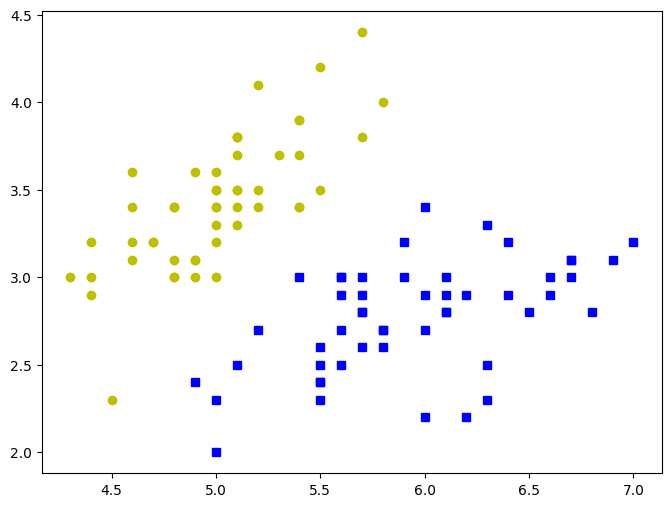

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(X_reshaped[:, 0][y_reshaped==0], X_reshaped[:, 1][y_reshaped==0], "yo")
plt.plot(X_reshaped[:, 0][y_reshaped==1], X_reshaped[:, 1][y_reshaped==1], "bs")
plt.show()

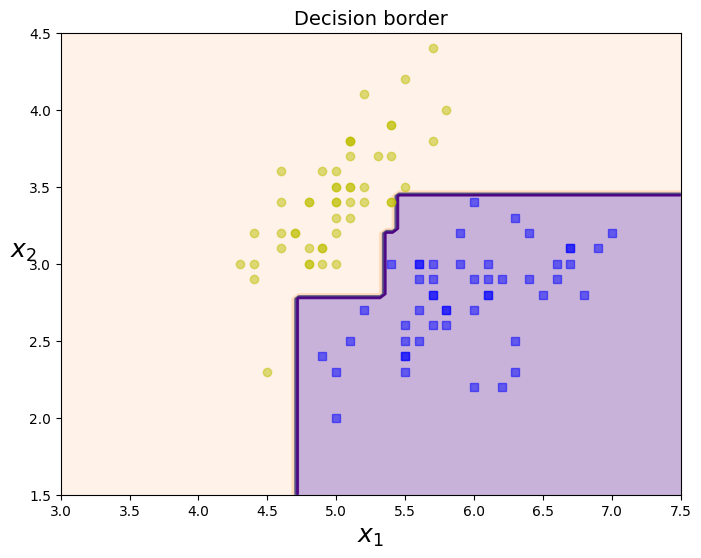

In [ ]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, X_reshaped, y_reshaped, axes=[3.0, 7.5, 1.5, 4.5])
plt.title("Decision border", fontsize=14)
plt.show()

> Запомним, что один из последних сплитов происходит для оси $x_1$ (или x[0]) в визуализации дерева по условию `x[0]<=4.7` для нашей **исходной даты**.

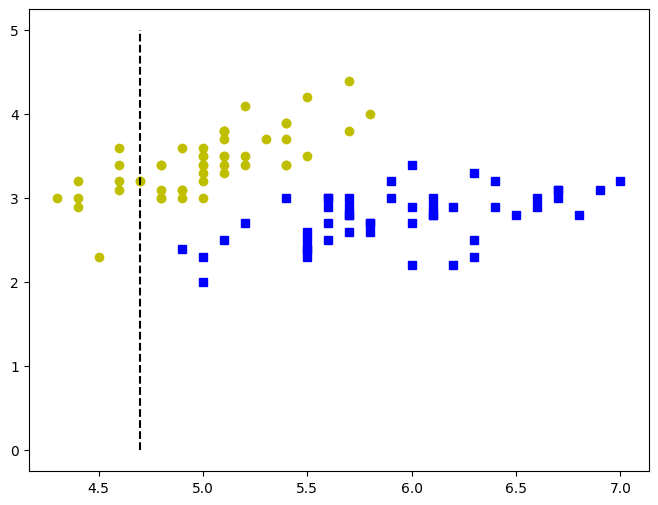

In [ ]:
#Let's generate this split-line
points=[]
for x in np.linspace(0, 5, 50):
    y1 = 4.7
    y2 = x
    points.append((y1, y2))

points = np.array(points)

plt.figure(figsize=(8, 6))
plt.plot(X_reshaped[:, 0][y_reshaped==0], X_reshaped[:, 1][y_reshaped==0], "yo")
plt.plot(X_reshaped[:, 0][y_reshaped==1], X_reshaped[:, 1][y_reshaped==1], "bs")
plt.plot(points[:, 0], points[:, 1], c='black', ls='--')
plt.show()

Возьмём эту границу в наши дальнейшие эксперименты и будем её вращать вместе с данными.

Тут немного как происходит сплитинг с деревьями разной глубины. Для сравнения также Random Forest.

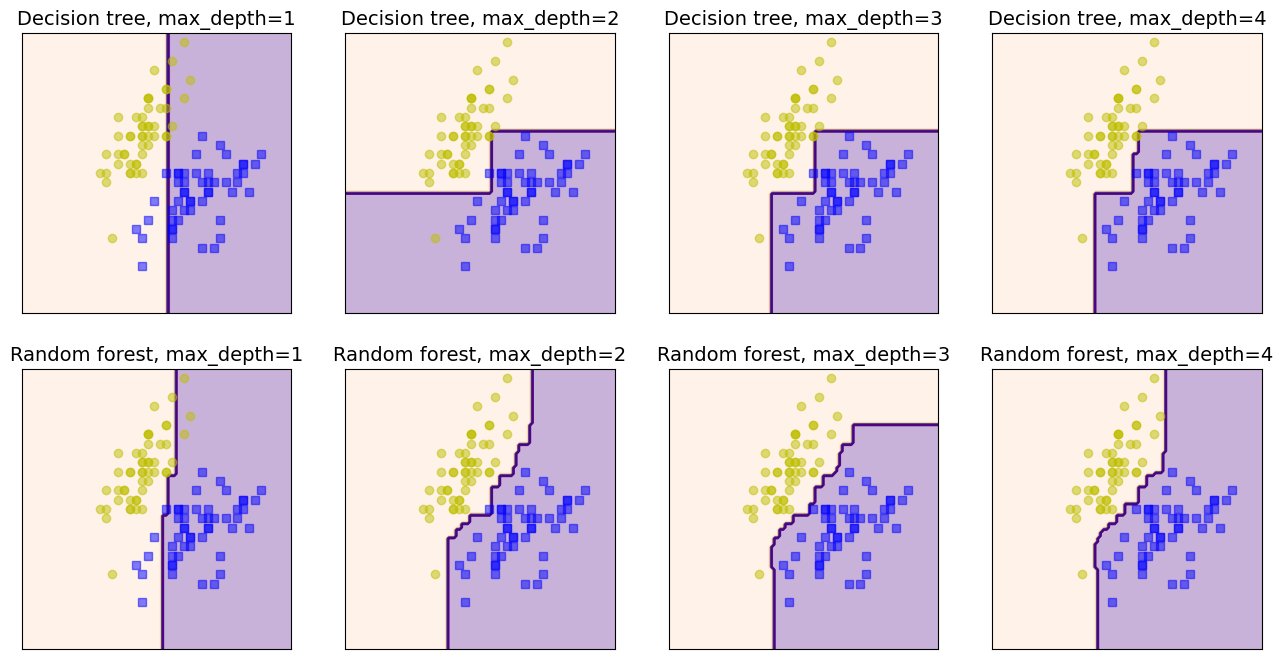

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(X_reshaped, y_reshaped)
plot_decision_boundary(dt1, X_reshaped, y_reshaped, axes=[3.0, 7.5, 1.5, 4.5])
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = DecisionTreeClassifier(max_depth=2)
dt3.fit(X_reshaped, y_reshaped)
plot_decision_boundary(dt3, X_reshaped, y_reshaped, axes=[3.0, 7.5, 1.5, 4.5])
plt.title("Decision tree, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = DecisionTreeClassifier(max_depth=3)
dt5.fit(X_reshaped, y_reshaped)
plot_decision_boundary(dt5, X_reshaped, y_reshaped, axes=[3.0, 7.5, 1.5, 4.5])
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = DecisionTreeClassifier(max_depth=4)
dt12.fit(X_reshaped, y_reshaped)
plot_decision_boundary(dt12, X_reshaped, y_reshaped, axes=[3.0, 7.5, 1.5, 4.5])
plt.title("Decision tree, max_depth=4", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1)
rf1.fit(X_reshaped, y_reshaped)
plot_decision_boundary(rf1, X_reshaped, y_reshaped, axes=[3.0, 7.5, 1.5, 4.5])
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifier(max_depth=2, n_estimators=500, n_jobs=-1)
rf3.fit(X_reshaped, y_reshaped)
plot_decision_boundary(rf3, X_reshaped, y_reshaped, axes=[3.0, 7.5, 1.5, 4.5])
plt.title("Random forest, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1)
rf5.fit(X_reshaped, y_reshaped)
plot_decision_boundary(rf5, X_reshaped, y_reshaped, axes=[3.0, 7.5, 1.5, 4.5])
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1)
rf12.fit(X_reshaped, y_reshaped)
plot_decision_boundary(rf12, X_reshaped, y_reshaped, axes=[3.0, 7.5, 1.5, 4.5])
plt.title("Random forest, max_depth=4", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

## Вращаем

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target

In [ ]:
X_reshaped = np.concatenate((np.column_stack((X[:, 0][y==0], X[:, 1][y==0])), np.column_stack((X[:, 0][y==1], X[:, 1][y==1]))), axis=0)
y_reshaped = np.concatenate((np.zeros(len(X[:, 0][y==0])), np.ones(len(X[:, 0][y==1]))), axis=0)

<Figure size 1000x500 with 0 Axes>

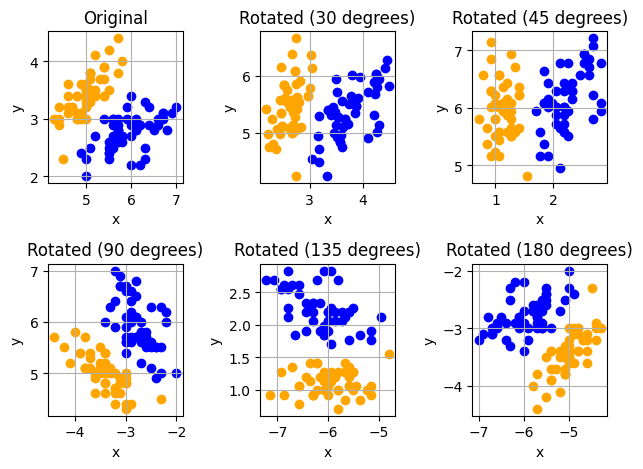

In [ ]:
array = X_reshaped

plt.figure(figsize=(10, 5))
fig, axs = plt.subplots(2, 3)

axs[0, 0].scatter(X_reshaped[:, 0][y_reshaped==0], X_reshaped[:, 1][y_reshaped==0], color="orange")
axs[0, 0].scatter(X_reshaped[:, 0][y_reshaped==1], X_reshaped[:, 1][y_reshaped==1], color="blue")
axs[0, 0].set_title('Original')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].grid()


angle = 30
theta = np.radians(angle)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
rotated_points_30 = array @ rotation_matrix.T#df[['x', 'y']].values @ rotation_matrix.T
rotated_points_30_b = points @ rotation_matrix.T
axs[0, 1].scatter(rotated_points_30[:, 0][y_reshaped==0], rotated_points_30[:, 1][y_reshaped==0], color="orange")
axs[0, 1].scatter(rotated_points_30[:, 0][y_reshaped==1], rotated_points_30[:, 1][y_reshaped==1], color="blue")
axs[0, 1].set_title(f'Rotated ({angle} градусов)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
axs[0, 1].grid()


angle = 45
theta = np.radians(angle)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
rotated_points_45 = array @ rotation_matrix.T#df[['x', 'y']].values @ rotation_matrix.T
rotated_points_45_b = points @ rotation_matrix.T
axs[0, 2].scatter(rotated_points_45[:, 0][y_reshaped==0], rotated_points_45[:, 1][y_reshaped==0], color="orange")
axs[0, 2].scatter(rotated_points_45[:, 0][y_reshaped==1], rotated_points_45[:, 1][y_reshaped==1], color="blue")
axs[0, 2].set_title(f'Rotated ({angle} градусов)')
axs[0, 2].set_xlabel('x')
axs[0, 2].set_ylabel('y')
axs[0, 2].grid()

angle = 90
theta = np.radians(angle)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
rotated_points_90 = array @ rotation_matrix.T#df[['x', 'y']].values @ rotation_matrix.T
rotated_points_90_b = points @ rotation_matrix.T
axs[1, 0].scatter(rotated_points_90[:, 0][y_reshaped==0], rotated_points_90[:, 1][y_reshaped==0], color="orange")
axs[1, 0].scatter(rotated_points_90[:, 0][y_reshaped==1], rotated_points_90[:, 1][y_reshaped==1], color="blue")
axs[1, 0].set_title(f'Rotated ({angle} градусов)')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
axs[1, 0].grid()


angle = 135
theta = np.radians(angle)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
rotated_points_135 = array @ rotation_matrix.T#df[['x', 'y']].values @ rotation_matrix.T
rotated_points_135_b = points @ rotation_matrix.T
axs[1, 1].scatter(rotated_points_135[:, 0][y_reshaped==0], rotated_points_135[:, 1][y_reshaped==0], color="orange")
axs[1, 1].scatter(rotated_points_135[:, 0][y_reshaped==1], rotated_points_135[:, 1][y_reshaped==1], color="blue")
axs[1, 1].set_title(f'Rotated ({angle} градусов)')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
axs[1, 1].grid()


angle = 180
theta = np.radians(angle)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
rotated_points_180 = array @ rotation_matrix.T#df[['x', 'y']].values @ rotation_matrix.T
rotated_points_180_b = points @ rotation_matrix.T
axs[1, 2].scatter(rotated_points_180[:, 0][y_reshaped==0], rotated_points_180[:, 1][y_reshaped==0], color="orange")
axs[1, 2].scatter(rotated_points_180[:, 0][y_reshaped==1], rotated_points_180[:, 1][y_reshaped==1], color="blue")
axs[1, 2].set_title(f'Rotated ({angle} градусов)')
axs[1, 2].set_xlabel('x')
axs[1, 2].set_ylabel('y')
axs[1, 2].grid()

plt.tight_layout();

#### 30 градусов

In [ ]:
min_x = min(rotated_points_30[:, 0]) - 0.1
max_x = max(rotated_points_30[:, 0]) + 0.1
min_y = min(rotated_points_30[:, 1]) - 0.1
max_y = max(rotated_points_30[:, 1]) + 0.1

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(rotated_points_30, y_reshaped)

[Text(0.5, 0.75, 'x[0] <= 3.04\ngini = 0.5\nsamples = 100\nvalue = [50, 50]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 50\nvalue = [50, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 50\nvalue = [0, 50]'),
 Text(0.625, 0.5, '  False')]

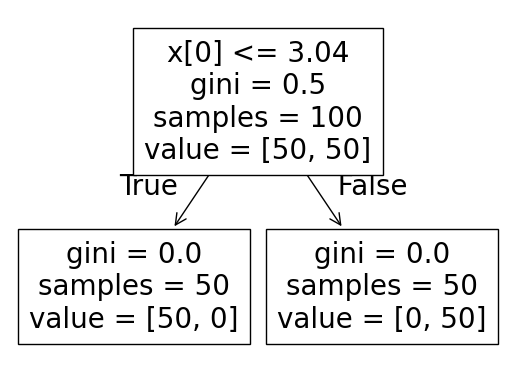

In [ ]:
plot_tree(clf)

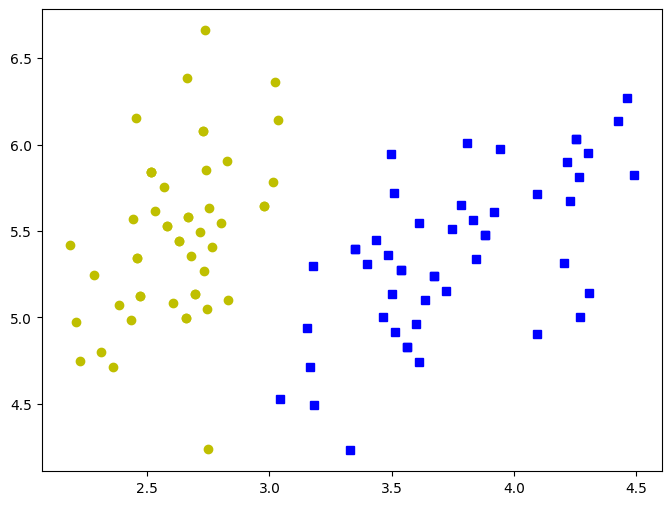

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(rotated_points_30[:, 0][y_reshaped==0], rotated_points_30[:, 1][y_reshaped==0], "yo")
plt.plot(rotated_points_30[:, 0][y_reshaped==1], rotated_points_30[:, 1][y_reshaped==1], "bs")
plt.show()

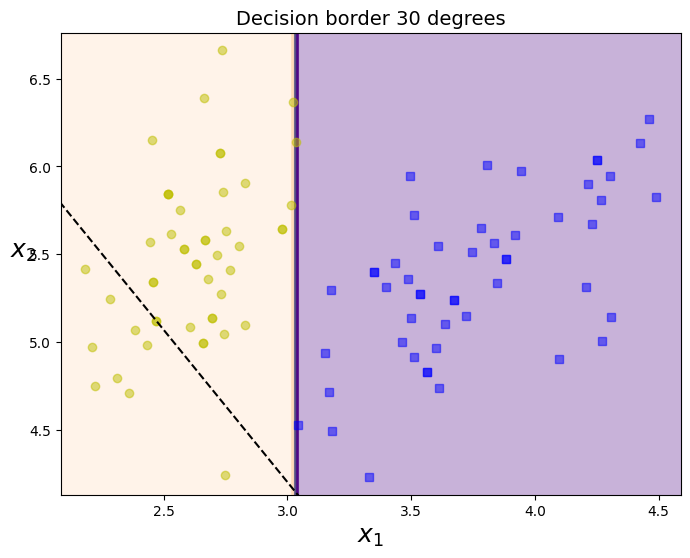

In [ ]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, rotated_points_30, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.plot(rotated_points_30_b[:, 0], rotated_points_30_b[:, 1], c='black', ls='--')
plt.title("Decision border 30 градусов", fontsize=14)
plt.show()

Вы заметили, что дерево решений работает достаточно чопорно и сплитит просто прямыми линиями по вертикали или горизонтали. Тем не менее наше вращение пространства объектов изменило проекцию или "тень" данных на оси. Но пока новая граница пересекает ось x в той же точке, что и исходная граница. Давайте едем дальше! 

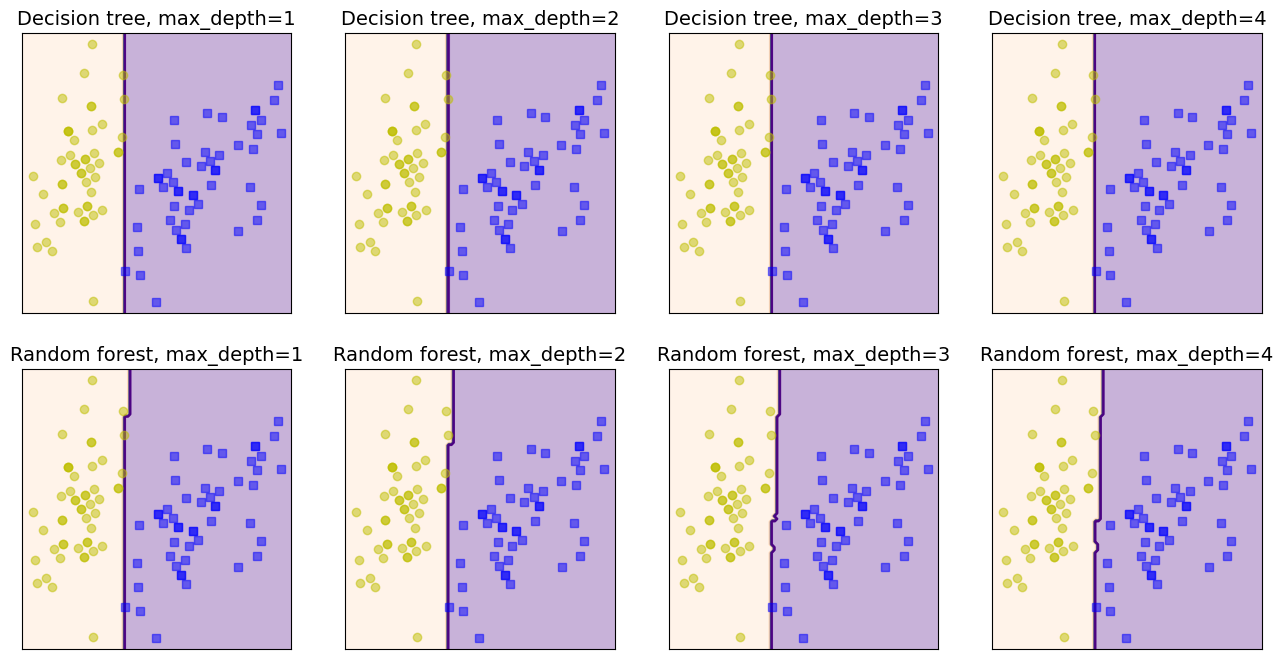

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(rotated_points_30, y_reshaped)
plot_decision_boundary(dt1, rotated_points_30, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = DecisionTreeClassifier(max_depth=2)
dt3.fit(rotated_points_30, y_reshaped)
plot_decision_boundary(dt3, rotated_points_30, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = DecisionTreeClassifier(max_depth=3)
dt5.fit(rotated_points_30, y_reshaped)
plot_decision_boundary(dt5, rotated_points_30, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = DecisionTreeClassifier(max_depth=4)
dt12.fit(rotated_points_30, y_reshaped)
plot_decision_boundary(dt12, rotated_points_30, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=4", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1)
rf1.fit(rotated_points_30, y_reshaped)
plot_decision_boundary(rf1, rotated_points_30, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifier(max_depth=2, n_estimators=500, n_jobs=-1)
rf3.fit(rotated_points_30, y_reshaped)
plot_decision_boundary(rf3, rotated_points_30, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1)
rf5.fit(rotated_points_30, y_reshaped)
plot_decision_boundary(rf5, rotated_points_30, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1)
rf12.fit(rotated_points_30, y_reshaped)
plot_decision_boundary(rf12, rotated_points_30, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=4", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

#### 45 градусов

In [ ]:
min_x = min(rotated_points_45[:, 0]) - 0.1
max_x = max(rotated_points_45[:, 0]) + 0.1
min_y = min(rotated_points_45[:, 1]) - 0.1
max_y = max(rotated_points_45[:, 1]) + 0.1

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(rotated_points_45, y_reshaped)

[Text(0.5, 0.75, 'x[0] <= 1.626\ngini = 0.5\nsamples = 100\nvalue = [50, 50]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 50\nvalue = [50, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 50\nvalue = [0, 50]'),
 Text(0.625, 0.5, '  False')]

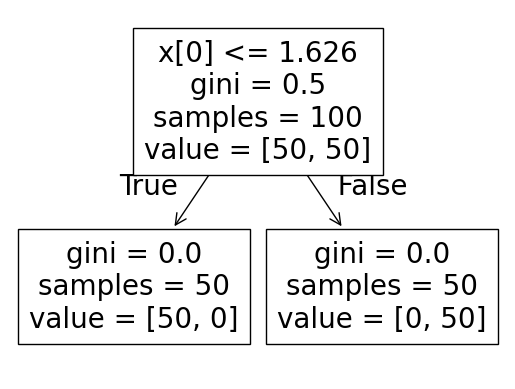

In [ ]:
plot_tree(clf)

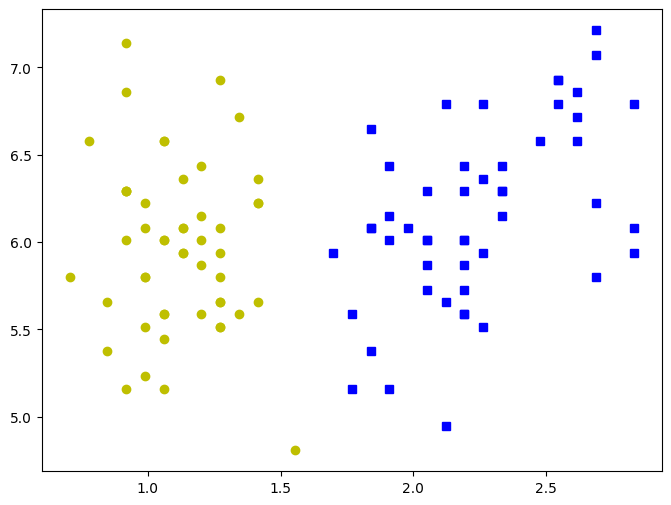

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(rotated_points_45[:, 0][y_reshaped==0], rotated_points_45[:, 1][y_reshaped==0], "yo")
plt.plot(rotated_points_45[:, 0][y_reshaped==1], rotated_points_45[:, 1][y_reshaped==1], "bs")
plt.show()

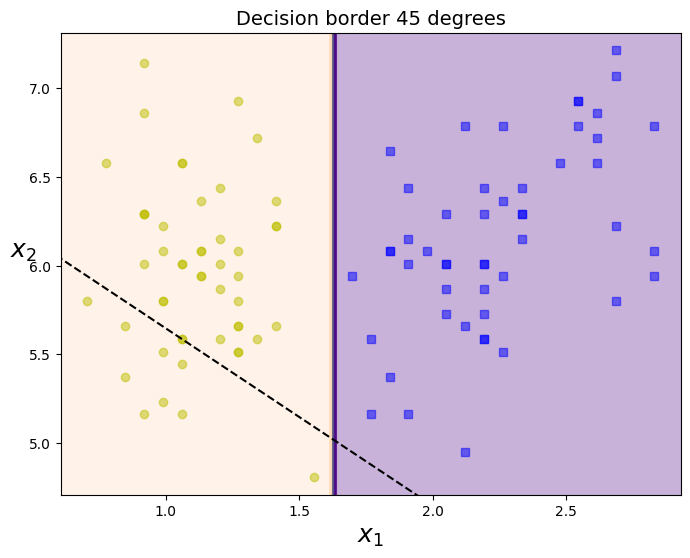

In [ ]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, rotated_points_45, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.plot(rotated_points_45_b[:, 0], rotated_points_45_b[:, 1], c='black', ls='--')
plt.title("Decision border 45 градусов", fontsize=14)
plt.show()

А вот тут мы уже видим, что нашлась совершенно другая граница.

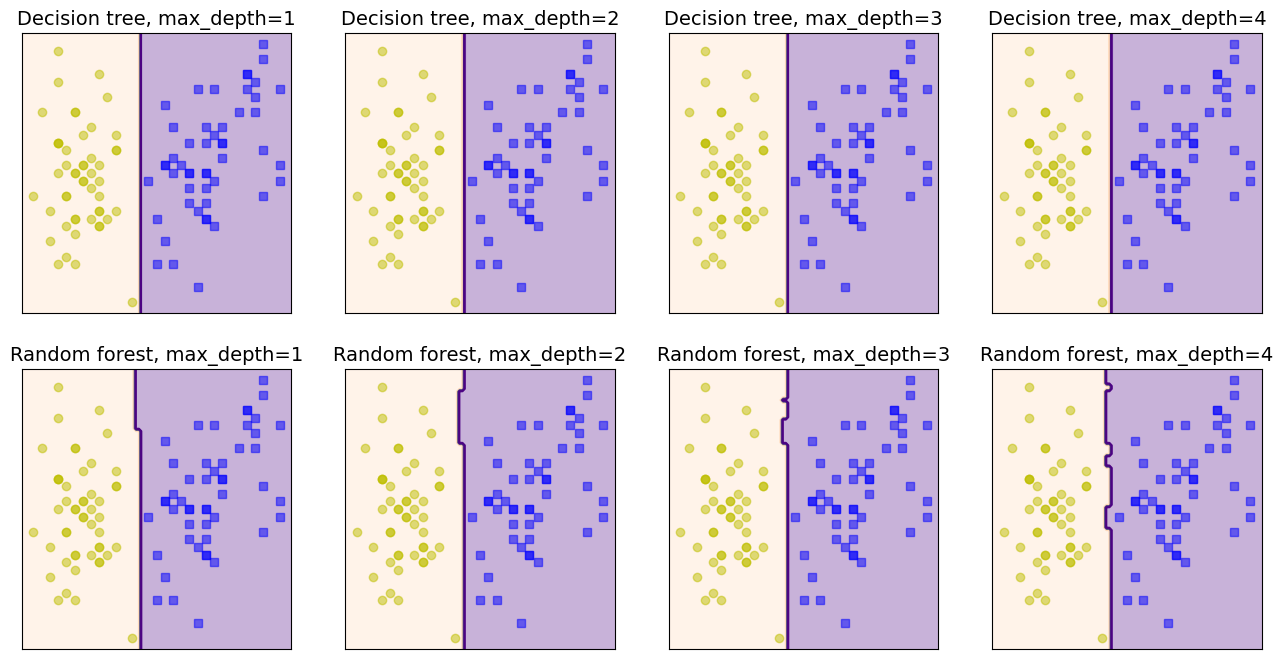

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(rotated_points_45, y_reshaped)
plot_decision_boundary(dt1, rotated_points_45, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = DecisionTreeClassifier(max_depth=2)
dt3.fit(rotated_points_45, y_reshaped)
plot_decision_boundary(dt3, rotated_points_45, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = DecisionTreeClassifier(max_depth=3)
dt5.fit(rotated_points_45, y_reshaped)
plot_decision_boundary(dt5, rotated_points_45, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = DecisionTreeClassifier(max_depth=4)
dt12.fit(rotated_points_45, y_reshaped)
plot_decision_boundary(dt12, rotated_points_45, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=4", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1)
rf1.fit(rotated_points_45, y_reshaped)
plot_decision_boundary(rf1, rotated_points_45, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifier(max_depth=2, n_estimators=500, n_jobs=-1)
rf3.fit(rotated_points_45, y_reshaped)
plot_decision_boundary(rf3, rotated_points_45, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1)
rf5.fit(rotated_points_45, y_reshaped)
plot_decision_boundary(rf5, rotated_points_45, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1)
rf12.fit(rotated_points_45, y_reshaped)
plot_decision_boundary(rf12, rotated_points_45, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=4", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

#### 90 градусов

In [ ]:
min_x = min(rotated_points_90[:, 0]) - 0.1
max_x = max(rotated_points_90[:, 0]) + 0.1
min_y = min(rotated_points_90[:, 1]) - 0.1
max_y = max(rotated_points_90[:, 1]) + 0.1

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(rotated_points_90, y_reshaped)

[Text(0.5909090909090909, 0.9, 'x[1] <= 5.45\ngini = 0.5\nsamples = 100\nvalue = [50, 50]'),
 Text(0.36363636363636365, 0.7, 'x[0] <= -2.8\ngini = 0.208\nsamples = 51\nvalue = [45, 6]'),
 Text(0.4772727272727273, 0.8, 'True  '),
 Text(0.18181818181818182, 0.5, 'x[1] <= 5.35\ngini = 0.043\nsamples = 45\nvalue = [44, 1]'),
 Text(0.09090909090909091, 0.3, 'gini = 0.0\nsamples = 39\nvalue = [39, 0]'),
 Text(0.2727272727272727, 0.3, 'x[0] <= -3.2\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(0.18181818181818182, 0.1, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.36363636363636365, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.5454545454545454, 0.5, 'x[1] <= 4.7\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.45454545454545453, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6363636363636364, 0.3, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.8181818181818182, 0.7, 'x[0] <= -3.45\ngini = 0.183\nsamples = 49\nvalue = [5, 44]'),
 Text(0.7045454545454

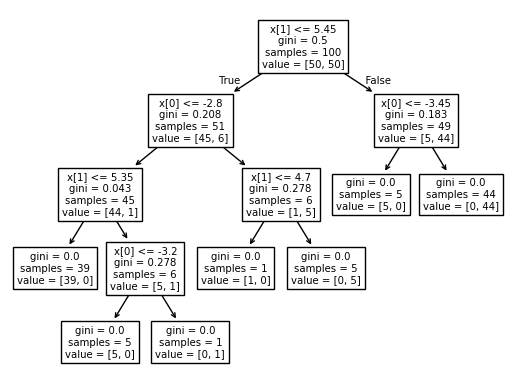

In [ ]:
plot_tree(clf)

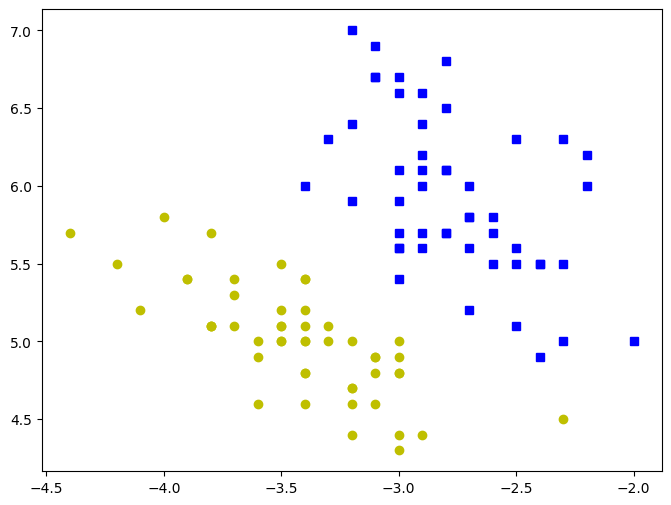

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(rotated_points_90[:, 0][y_reshaped==0], rotated_points_90[:, 1][y_reshaped==0], "yo")
plt.plot(rotated_points_90[:, 0][y_reshaped==1], rotated_points_90[:, 1][y_reshaped==1], "bs")
plt.show()

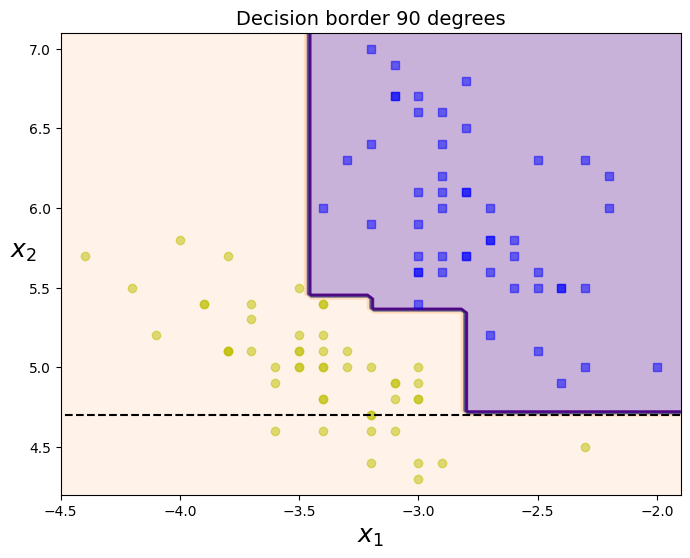

In [ ]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, rotated_points_90, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.plot(rotated_points_90_b[:, 0], rotated_points_90_b[:, 1], c='black', ls='--')
plt.title("Decision border 90 градусов", fontsize=14)
plt.show()

Заметьте, что при повороте на **90 градусов** мы на самом деле нашли **"те же самые границы"**, но тоже **повёрнутые на 90 градусов**. Наш последний сплитинг - это `x[1]<=4.7`, т.е. просто другая ось, в которую переходит наш изначальных x при повороте на 90 градусов.

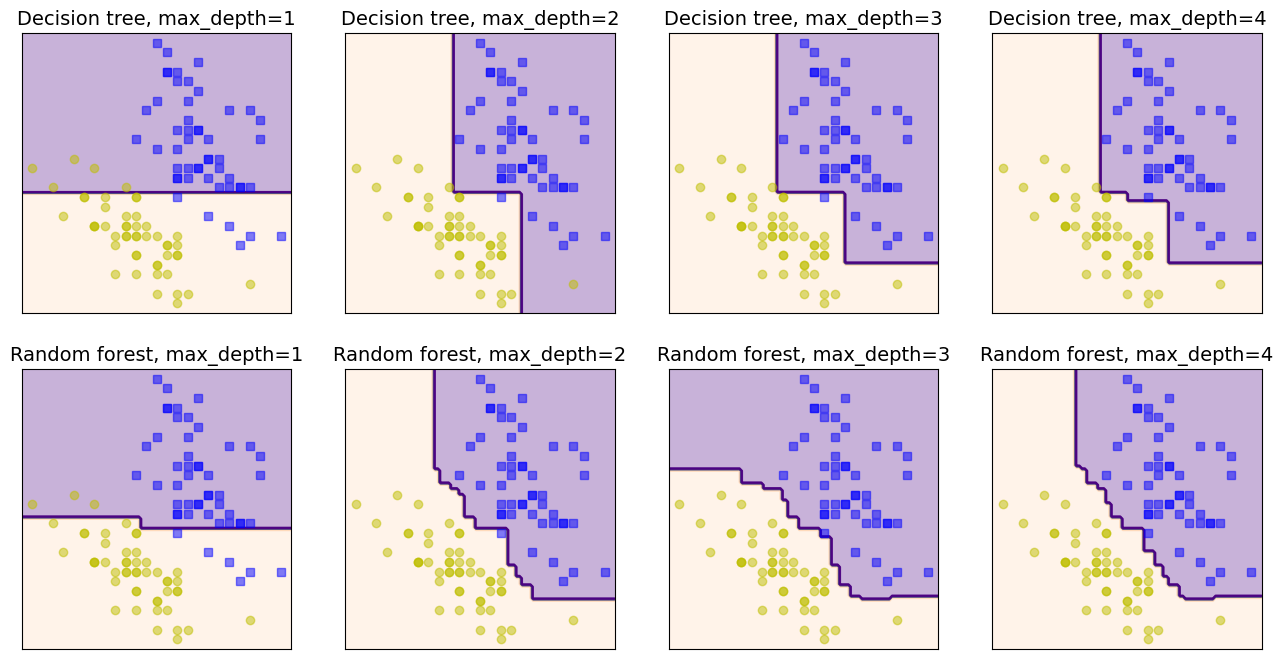

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(rotated_points_90, y_reshaped)
plot_decision_boundary(dt1, rotated_points_90, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = DecisionTreeClassifier(max_depth=2)
dt3.fit(rotated_points_90, y_reshaped)
plot_decision_boundary(dt3, rotated_points_90, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = DecisionTreeClassifier(max_depth=3)
dt5.fit(rotated_points_90, y_reshaped)
plot_decision_boundary(dt5, rotated_points_90, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = DecisionTreeClassifier(max_depth=4)
dt12.fit(rotated_points_90, y_reshaped)
plot_decision_boundary(dt12, rotated_points_90, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=4", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1)
rf1.fit(rotated_points_90, y_reshaped)
plot_decision_boundary(rf1, rotated_points_90, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifier(max_depth=2, n_estimators=500, n_jobs=-1)
rf3.fit(rotated_points_90, y_reshaped)
plot_decision_boundary(rf3, rotated_points_90, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1)
rf5.fit(rotated_points_90, y_reshaped)
plot_decision_boundary(rf5, rotated_points_90, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1)
rf12.fit(rotated_points_90, y_reshaped)
plot_decision_boundary(rf12, rotated_points_90, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=4", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

#### 135 градусов

In [ ]:
min_x = min(rotated_points_135[:, 0]) - 0.1
max_x = max(rotated_points_135[:, 0]) + 0.1
min_y = min(rotated_points_135[:, 1]) - 0.1
max_y = max(rotated_points_135[:, 1]) + 0.1

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(rotated_points_135, y_reshaped)

[Text(0.5, 0.75, 'x[1] <= 1.626\ngini = 0.5\nsamples = 100\nvalue = [50, 50]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 50\nvalue = [50, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 50\nvalue = [0, 50]'),
 Text(0.625, 0.5, '  False')]

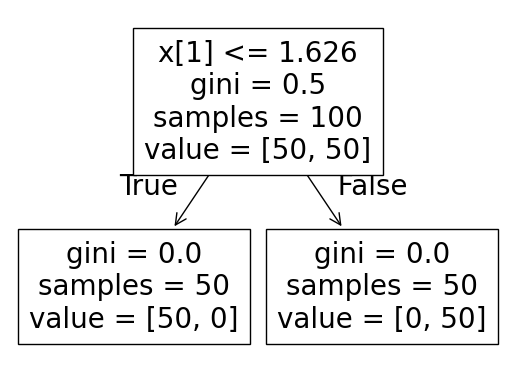

In [ ]:
plot_tree(clf)

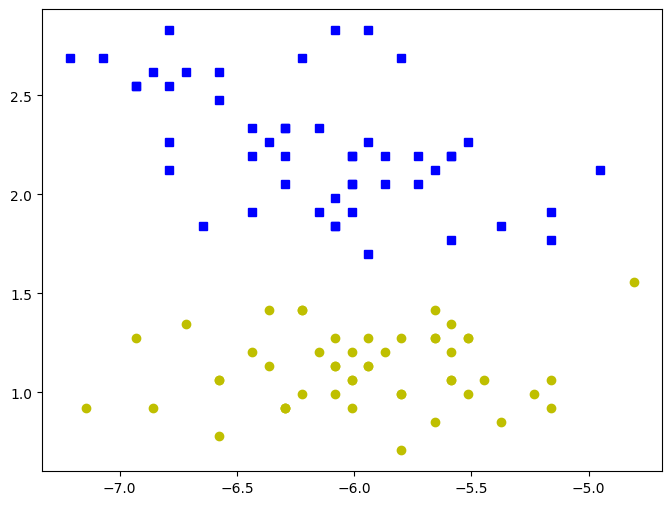

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(rotated_points_135[:, 0][y_reshaped==0], rotated_points_135[:, 1][y_reshaped==0], "yo")
plt.plot(rotated_points_135[:, 0][y_reshaped==1], rotated_points_135[:, 1][y_reshaped==1], "bs")
plt.show()

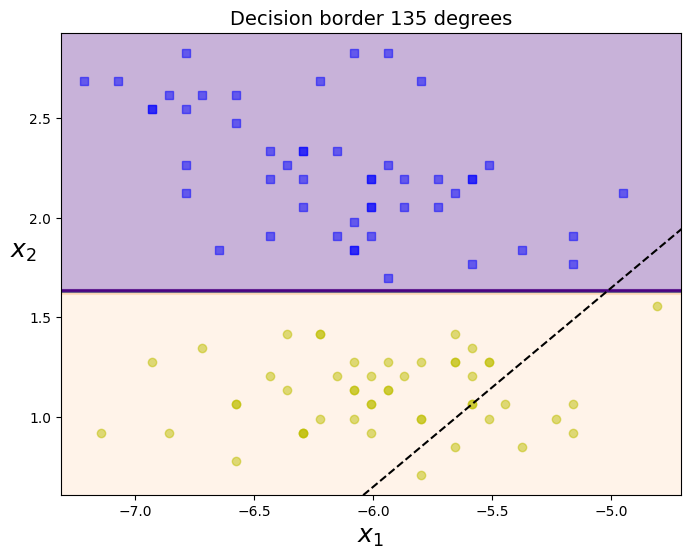

In [ ]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, rotated_points_135, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.plot(rotated_points_135_b[:, 0], rotated_points_135_b[:, 1], c='black', ls='--')
plt.title("Decision border 135 градусов", fontsize=14)
plt.show()

Аналогично 45 градусам, но поворот на + 90.

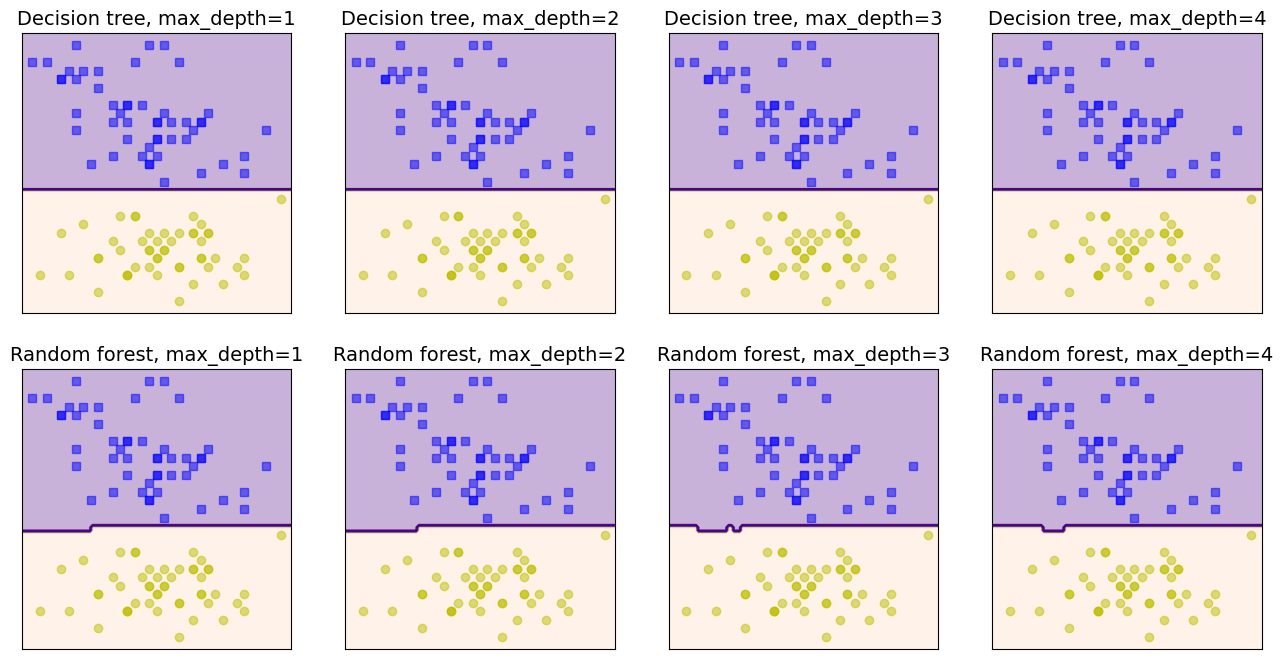

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(rotated_points_135, y_reshaped)
plot_decision_boundary(dt1, rotated_points_135, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = DecisionTreeClassifier(max_depth=2)
dt3.fit(rotated_points_135, y_reshaped)
plot_decision_boundary(dt3, rotated_points_135, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = DecisionTreeClassifier(max_depth=3)
dt5.fit(rotated_points_135, y_reshaped)
plot_decision_boundary(dt5, rotated_points_135, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = DecisionTreeClassifier(max_depth=4)
dt12.fit(rotated_points_135, y_reshaped)
plot_decision_boundary(dt12, rotated_points_135, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=4", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1)
rf1.fit(rotated_points_135, y_reshaped)
plot_decision_boundary(rf1, rotated_points_135, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifier(max_depth=2, n_estimators=500, n_jobs=-1)
rf3.fit(rotated_points_135, y_reshaped)
plot_decision_boundary(rf3, rotated_points_135, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1)
rf5.fit(rotated_points_135, y_reshaped)
plot_decision_boundary(rf5, rotated_points_135, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1)
rf12.fit(rotated_points_135, y_reshaped)
plot_decision_boundary(rf12, rotated_points_135, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=4", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

#### 180 градусов

In [ ]:
min_x = min(rotated_points_180[:, 0]) - 0.1
max_x = max(rotated_points_180[:, 0]) + 0.1
min_y = min(rotated_points_180[:, 1]) - 0.1
max_y = max(rotated_points_180[:, 1]) + 0.1

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(rotated_points_180, y_reshaped)

[Text(0.4090909090909091, 0.9, 'x[0] <= -5.45\ngini = 0.5\nsamples = 100\nvalue = [50, 50]'),
 Text(0.18181818181818182, 0.7, 'x[1] <= -3.45\ngini = 0.183\nsamples = 49\nvalue = [5, 44]'),
 Text(0.29545454545454547, 0.8, 'True  '),
 Text(0.09090909090909091, 0.5, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.2727272727272727, 0.5, 'gini = 0.0\nsamples = 44\nvalue = [0, 44]'),
 Text(0.6363636363636364, 0.7, 'x[1] <= -2.8\ngini = 0.208\nsamples = 51\nvalue = [45, 6]'),
 Text(0.5227272727272727, 0.8, '  False'),
 Text(0.45454545454545453, 0.5, 'x[0] <= -5.35\ngini = 0.043\nsamples = 45\nvalue = [44, 1]'),
 Text(0.36363636363636365, 0.3, 'x[1] <= -3.2\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(0.2727272727272727, 0.1, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.45454545454545453, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.5454545454545454, 0.3, 'gini = 0.0\nsamples = 39\nvalue = [39, 0]'),
 Text(0.8181818181818182, 0.5, 'x[0] <= -4.7\ngini = 0.278\nsamp

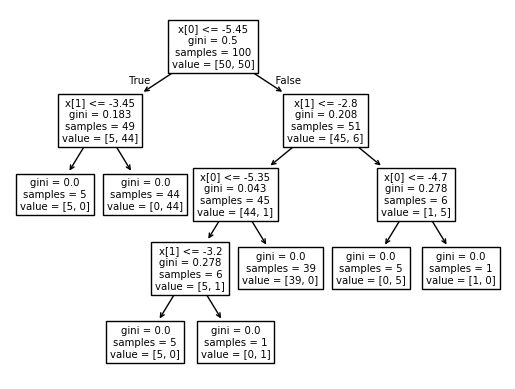

In [ ]:
plot_tree(clf)

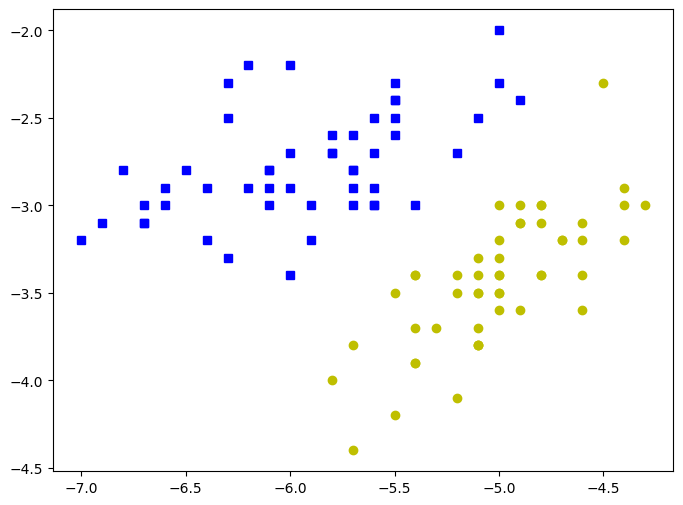

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(rotated_points_180[:, 0][y_reshaped==0], rotated_points_180[:, 1][y_reshaped==0], "yo")
plt.plot(rotated_points_180[:, 0][y_reshaped==1], rotated_points_180[:, 1][y_reshaped==1], "bs")
plt.show()

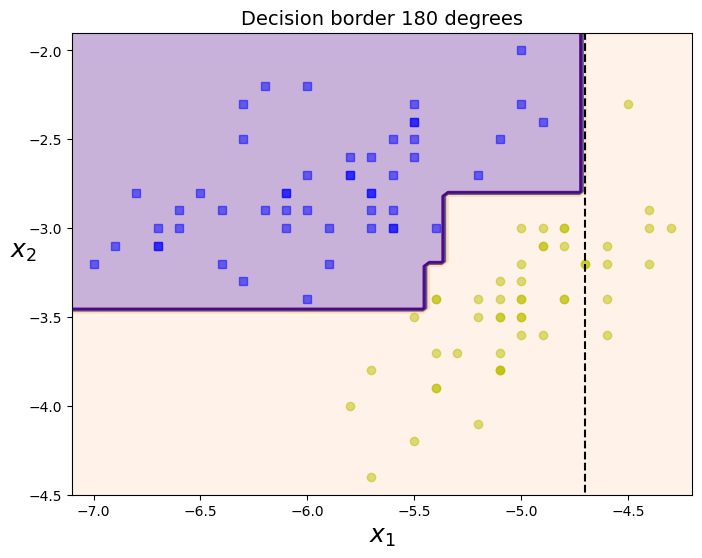

In [ ]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, rotated_points_180, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.plot(rotated_points_180_b[:, 0], rotated_points_180_b[:, 1], c='black', ls='--')
plt.title("Decision border 180 градусов", fontsize=14)
plt.show()

Как изначальные данные, но вверх ногами

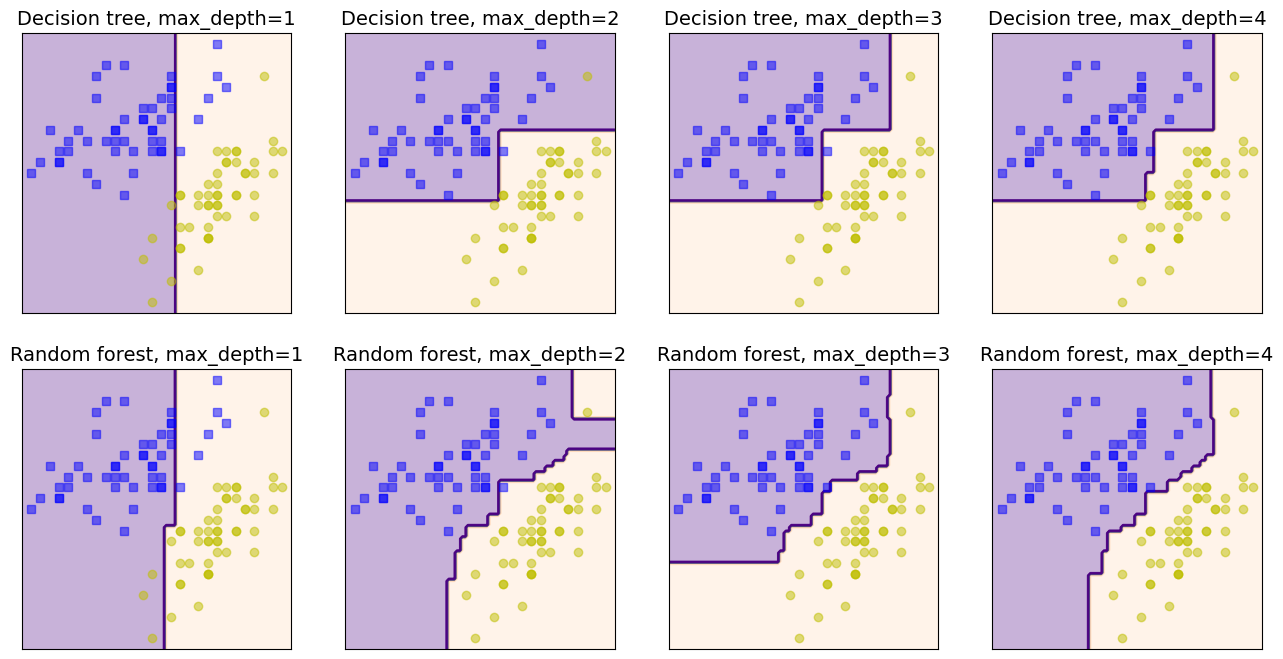

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(rotated_points_180, y_reshaped)
plot_decision_boundary(dt1, rotated_points_180, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = DecisionTreeClassifier(max_depth=2)
dt3.fit(rotated_points_180, y_reshaped)
plot_decision_boundary(dt3, rotated_points_180, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = DecisionTreeClassifier(max_depth=3)
dt5.fit(rotated_points_180, y_reshaped)
plot_decision_boundary(dt5, rotated_points_180, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = DecisionTreeClassifier(max_depth=4)
dt12.fit(rotated_points_180, y_reshaped)
plot_decision_boundary(dt12, rotated_points_180, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=4", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1)
rf1.fit(rotated_points_180, y_reshaped)
plot_decision_boundary(rf1, rotated_points_180, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifier(max_depth=2, n_estimators=500, n_jobs=-1)
rf3.fit(rotated_points_180, y_reshaped)
plot_decision_boundary(rf3, rotated_points_180, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1)
rf5.fit(rotated_points_180, y_reshaped)
plot_decision_boundary(rf5, rotated_points_180, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1)
rf12.fit(rotated_points_180, y_reshaped)
plot_decision_boundary(rf12, rotated_points_180, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=4", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

#### 57 градусов

<Figure size 1000x500 with 0 Axes>

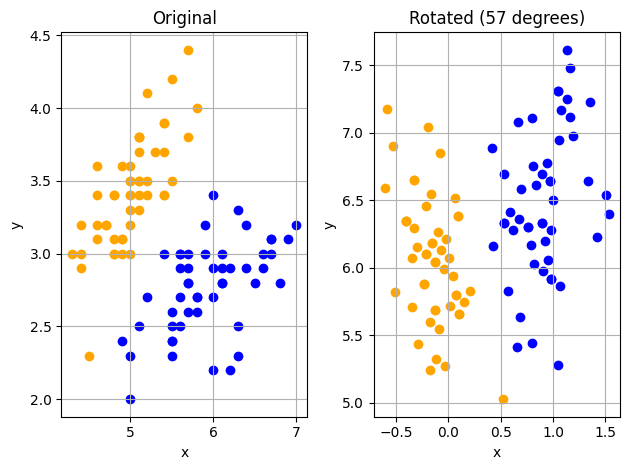

In [ ]:
array = X_reshaped

plt.figure(figsize=(10, 5))
fig, axs = plt.subplots(1, 2)

axs[0].scatter(X_reshaped[:, 0][y_reshaped==0], X_reshaped[:, 1][y_reshaped==0], color="orange")
axs[0].scatter(X_reshaped[:, 0][y_reshaped==1], X_reshaped[:, 1][y_reshaped==1], color="blue")
axs[0].set_title('Original')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()


angle = 57
theta = np.radians(angle)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
rotated_points_57 = array @ rotation_matrix.T#df[['x', 'y']].values @ rotation_matrix.T
rotated_points_57_b = points @ rotation_matrix.T
axs[1].scatter(rotated_points_57[:, 0][y_reshaped==0], rotated_points_57[:, 1][y_reshaped==0], color="orange")
axs[1].scatter(rotated_points_57[:, 0][y_reshaped==1], rotated_points_57[:, 1][y_reshaped==1], color="blue")
axs[1].set_title(f'Rotated ({angle} градусов)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].grid()

plt.tight_layout();

In [ ]:
min_x = min(rotated_points_57[:, 0]) - 0.1
max_x = max(rotated_points_57[:, 0]) + 0.1
min_y = min(rotated_points_57[:, 1]) - 0.1
max_y = max(rotated_points_57[:, 1]) + 0.1

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(rotated_points_57, y_reshaped)

[Text(0.4, 0.8333333333333334, 'x[0] <= 0.312\ngini = 0.5\nsamples = 100\nvalue = [50, 50]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 49\nvalue = [49, 0]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[1] <= 5.155\ngini = 0.038\nsamples = 51\nvalue = [1, 50]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 50\nvalue = [0, 50]')]

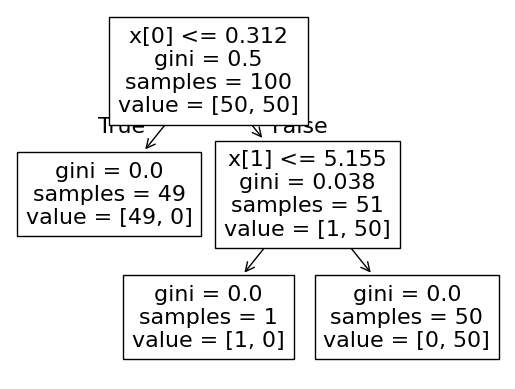

In [ ]:
plot_tree(clf)

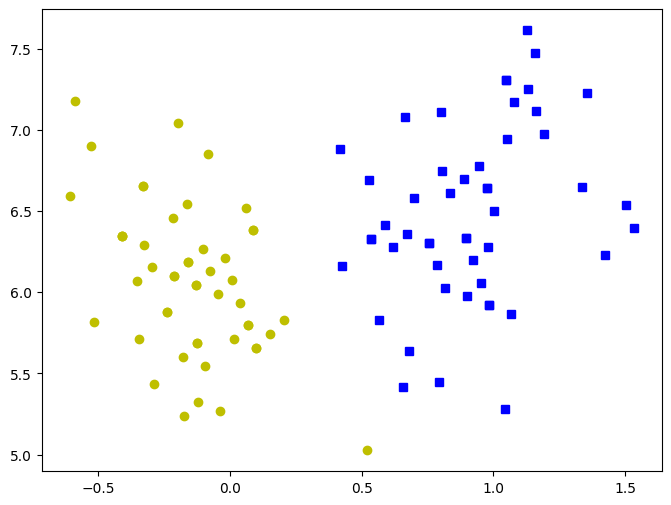

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(rotated_points_57[:, 0][y_reshaped==0], rotated_points_57[:, 1][y_reshaped==0], "yo")
plt.plot(rotated_points_57[:, 0][y_reshaped==1], rotated_points_57[:, 1][y_reshaped==1], "bs")
plt.show()

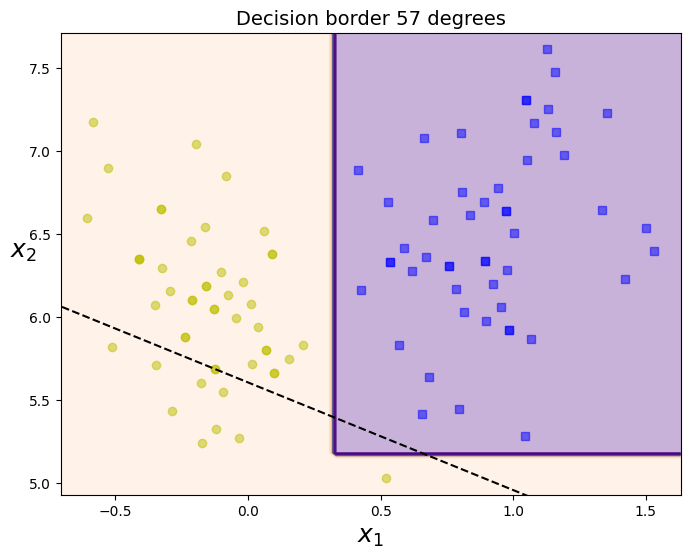

In [ ]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, rotated_points_57, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.plot(rotated_points_57_b[:, 0], rotated_points_57_b[:, 1], c='black', ls='--')
plt.title("Decision border 57 градусов", fontsize=14)
plt.show()

Здесь совсем другие границы

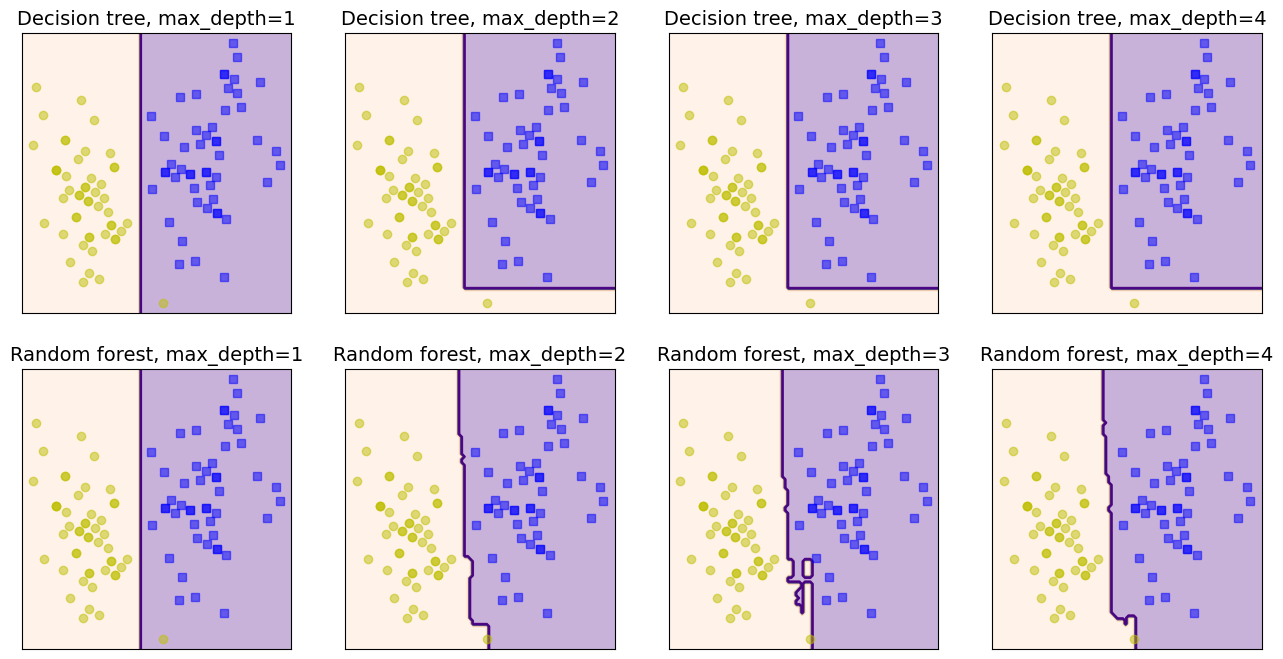

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(rotated_points_57, y_reshaped)
plot_decision_boundary(dt1, rotated_points_57, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = DecisionTreeClassifier(max_depth=2)
dt3.fit(rotated_points_57, y_reshaped)
plot_decision_boundary(dt3, rotated_points_57, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = DecisionTreeClassifier(max_depth=3)
dt5.fit(rotated_points_57, y_reshaped)
plot_decision_boundary(dt5, rotated_points_57, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = DecisionTreeClassifier(max_depth=4)
dt12.fit(rotated_points_57, y_reshaped)
plot_decision_boundary(dt12, rotated_points_57, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Decision tree, max_depth=4", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1)
rf1.fit(rotated_points_57, y_reshaped)
plot_decision_boundary(rf1, rotated_points_57, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifier(max_depth=2, n_estimators=500, n_jobs=-1)
rf3.fit(rotated_points_57, y_reshaped)
plot_decision_boundary(rf3, rotated_points_57, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1)
rf5.fit(rotated_points_57, y_reshaped)
plot_decision_boundary(rf5, rotated_points_57, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1)
rf12.fit(rotated_points_57, y_reshaped)
plot_decision_boundary(rf12, rotated_points_57, y_reshaped, axes=[min_x, max_x, min_y, max_y])
plt.title("Random forest, max_depth=4", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

# Как модель находит границы

Здесь небольшой пример того, как мы заставим **Decision Tree** найти границы, которые сами же и придумаем.

,x,y,class
0,1.872701,12.359286,0
1,3.659970,7.782560,0
2,0.780093,2.027929,0
3,0.290418,11.260290,0
4,3.005575,9.204944,0
...,...,...,...
492,12.278284,23.100663,1
493,11.386906,20.940606,1
494,12.318492,21.766761,1
495,12.918281,20.388673,1


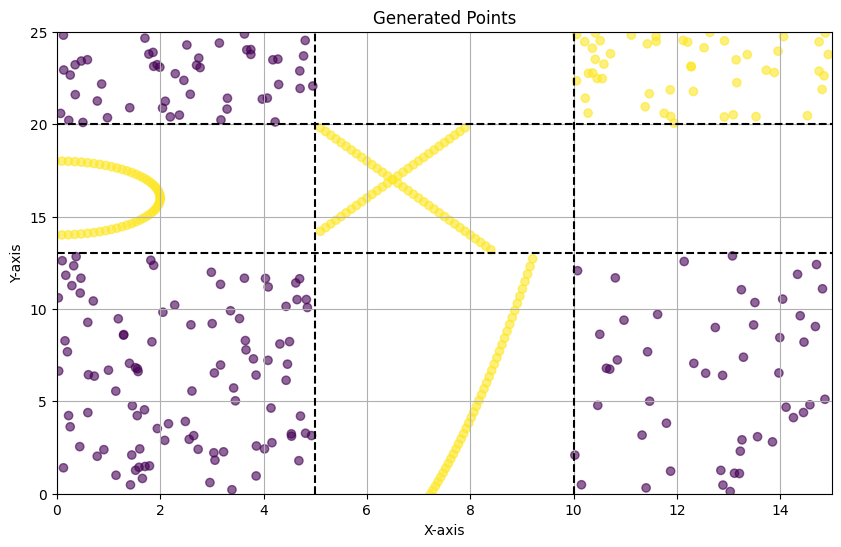

In [ ]:
# Data generation
np.random.seed(42)

points = []
classes = []

# Generate cloud of points from class 0 for x < 5 and y < 13
for _ in range(100):
    x = np.random.uniform(0, 5)
    y = np.random.uniform(0, 13)
    points.append((x, y))
    classes.append(0)

# Generate parabola points from class 1 for 5 < x < 10 and y < 13
for x in np.linspace(5.1, 10, 100):
    y = (x - 5) ** 2 - 5
    if y < 13:
        points.append((x, y))
        classes.append(1)

# Generate circle points from class 1 for x < 5 and 13 < y < 20
theta = np.linspace(0, 2 * np.pi, 100)
radius = 2
for t in theta:
    x = radius * np.cos(t)
    y = radius * np.sin(t) + 16
    if x < 5 and 13 < y < 20:
        points.append((x, y))
        classes.append(1)

# Generate two linear lines for 5 < x < 10 and 13 < y < 20
for x in np.linspace(5.1, 10, 50):
    y1 = 2 * (x - 5) + 14
    y2 = -2 * (x - 5) + 20
    if y1 > 13 and y1 < 20:
        points.append((x, y1))
        classes.append(1)
    if y2 > 13 and y2 < 20:
        points.append((x, y2))
        classes.append(1)

# Generate random points from class 0 for x > 10 and y < 13
for _ in range(50):
    x = np.random.uniform(10, 15)
    y = np.random.uniform(0, 13)
    points.append((x, y))
    classes.append(0)

# Generate random points for y > 20 and x < 5
for _ in range(50):
    x = np.random.uniform(0, 5)
    y = np.random.uniform(20, 25)
    points.append((x, y))
    classes.append(0)

# Generate random points for x > 10 and y > 20
for _ in range(50):
    x = np.random.uniform(10, 15)
    y = np.random.uniform(20, 25)
    points.append((x, y))
    classes.append(1)

df = pd.DataFrame(points, columns=['x', 'y'])
df['class'] = classes

display(df)

# Visualize the generated points
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c=df['class'], cmap='viridis', alpha=0.6)

# Add borders which I made up
plt.axvline(x = 5, color = 'black', ls='--')
plt.axvline(x = 10, color = 'black', ls='--')
plt.axhline(y = 13, color = 'black', ls='--')
plt.axhline(y = 20, color = 'black', ls='--')

plt.title('Generated Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(0, 15)
plt.ylim(0, 25)
plt.grid()
plt.show()

Наши искуственные границы: x = {**5, 10**}, y = {**13, 20**}. Давайте посмотрим, как моделька справится с ними.

In [ ]:
X_reshaped = np.column_stack((np.array(df['x']), np.array(df['y'])))
y_reshaped = np.array(df['class'])

clf = DecisionTreeClassifier()
clf = clf.fit(X_reshaped, y_reshaped)

[Text(0.4444444444444444, 0.875, 'x[1] <= 13.035\ngini = 0.481\nsamples = 497\nvalue = [200, 297]'),
 Text(0.2222222222222222, 0.625, 'x[0] <= 5.014\ngini = 0.46\nsamples = 234\nvalue = [150, 84]'),
 Text(0.3333333333333333, 0.75, 'True  '),
 Text(0.1111111111111111, 0.375, 'gini = 0.0\nsamples = 100\nvalue = [100, 0]'),
 Text(0.3333333333333333, 0.375, 'x[0] <= 9.617\ngini = 0.468\nsamples = 134\nvalue = [50, 84]'),
 Text(0.2222222222222222, 0.125, 'gini = 0.0\nsamples = 84\nvalue = [0, 84]'),
 Text(0.4444444444444444, 0.125, 'gini = 0.0\nsamples = 50\nvalue = [50, 0]'),
 Text(0.6666666666666666, 0.625, 'x[1] <= 20.073\ngini = 0.308\nsamples = 263\nvalue = [50, 213]'),
 Text(0.5555555555555556, 0.75, '  False'),
 Text(0.5555555555555556, 0.375, 'gini = 0.0\nsamples = 164\nvalue = [0, 164]'),
 Text(0.7777777777777778, 0.375, 'x[0] <= 7.505\ngini = 0.5\nsamples = 99\nvalue = [50, 49]'),
 Text(0.6666666666666666, 0.125, 'gini = 0.0\nsamples = 50\nvalue = [50, 0]'),
 Text(0.88888888888888

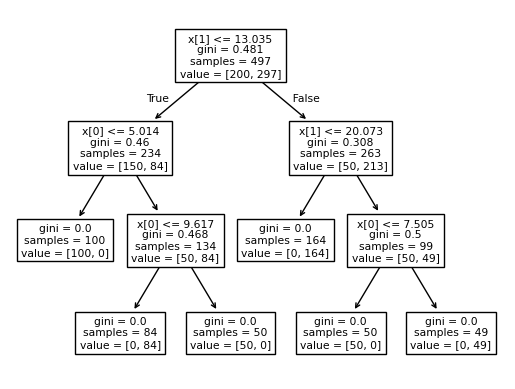

In [ ]:
plot_tree(clf)

Мы видим, что сплиттинг деревьев нашёл примерно те же границы: `x[1]<=13.035` (у нас было y=13) для depth=1, `x[0]<=5.014` (было x=5) и `x[1]<=20.073` (было y=20) для depth = 2, `x[0]<=9.617` (было x=10) для depth = 3

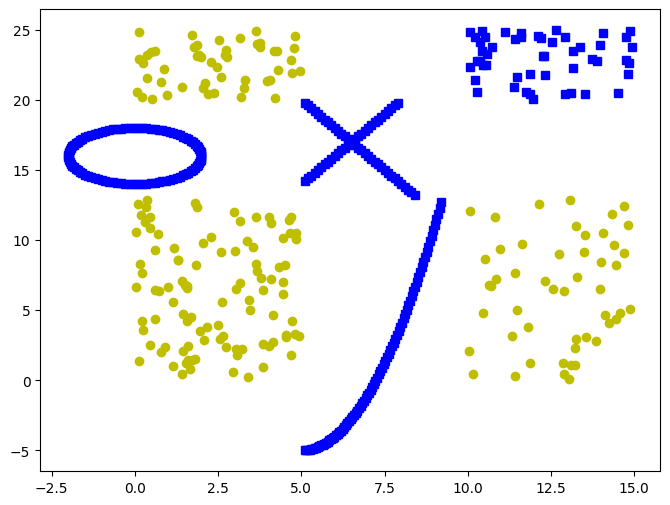

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(X_reshaped[:, 0][y_reshaped==0], X_reshaped[:, 1][y_reshaped==0], "yo")
plt.plot(X_reshaped[:, 0][y_reshaped==1], X_reshaped[:, 1][y_reshaped==1], "bs")
plt.show()

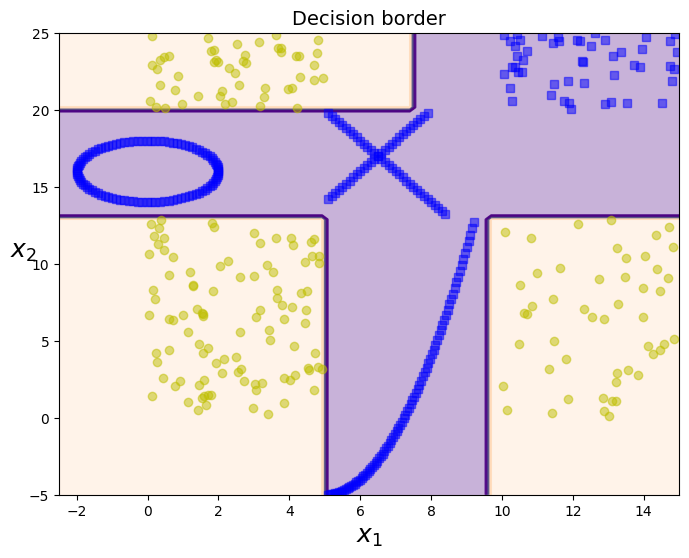

In [ ]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, X_reshaped, y_reshaped, axes=[-2.5, 15.0, -5, 25.0])
plt.title("Decision border", fontsize=14)
plt.show()

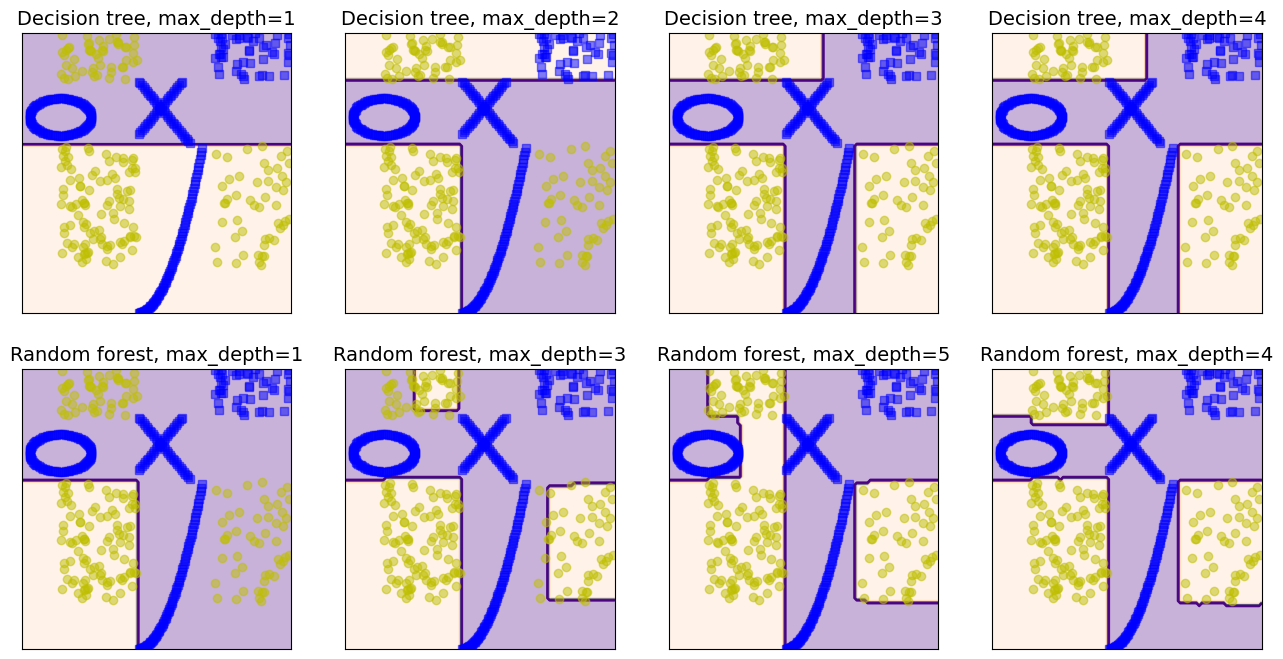

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(X_reshaped, y_reshaped)
plot_decision_boundary(dt1, X_reshaped, y_reshaped, axes=[-2.5, 15.0, -5, 25.0])
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = DecisionTreeClassifier(max_depth=2)
dt3.fit(X_reshaped, y_reshaped)
plot_decision_boundary(dt3, X_reshaped, y_reshaped, axes=[-2.5, 15.0, -5, 25.0])
plt.title("Decision tree, max_depth=2", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = DecisionTreeClassifier(max_depth=3)
dt5.fit(X_reshaped, y_reshaped)
plot_decision_boundary(dt5, X_reshaped, y_reshaped, axes=[-2.5, 15.0, -5, 25.0])
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt12 = DecisionTreeClassifier(max_depth=4)
dt12.fit(X_reshaped, y_reshaped)
plot_decision_boundary(dt12, X_reshaped, y_reshaped, axes=[-2.5, 15.0, -5, 25.0])
plt.title("Decision tree, max_depth=4", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
rf1 = RandomForestClassifier(max_depth=1, n_estimators=500, n_jobs=-1)
rf1.fit(X_reshaped, y_reshaped)
plot_decision_boundary(rf1, X_reshaped, y_reshaped, axes=[-2.5, 15.0, -5, 25.0])
plt.title("Random forest, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
rf3 = RandomForestClassifier(max_depth=2, n_estimators=500, n_jobs=-1)
rf3.fit(X_reshaped, y_reshaped)
plot_decision_boundary(rf3, X_reshaped, y_reshaped, axes=[-2.5, 15.0, -5, 25.0])
plt.title("Random forest, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
rf5 = RandomForestClassifier(max_depth=3, n_estimators=500, n_jobs=-1)
rf5.fit(X_reshaped, y_reshaped)
plot_decision_boundary(rf5, X_reshaped, y_reshaped, axes=[-2.5, 15.0, -5, 25.0])
plt.title("Random forest, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
rf12 = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1)
rf12.fit(X_reshaped, y_reshaped)
plot_decision_boundary(rf12, X_reshaped, y_reshaped, axes=[-2.5, 15.0, -5, 25.0])
plt.title("Random forest, max_depth=4", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);